In [1]:
# =============================================================================
# STEP 1A: Environment Setup - Install and Import All Required Libraries
# =============================================================================
# Google Colab comes with most ML libraries pre-installed.
# We only need to install SHAP (for model explainability) and optuna (for
# hyperparameter tuning) manually.

!pip install shap optuna --quiet

# --- Core Data Manipulation & Math ---
import pandas as pd                # Tabular data manipulation
import numpy as np                 # Numerical computing

# --- Visualization ---
import matplotlib.pyplot as plt    # Base plotting library
import seaborn as sns              # Statistical visualizations on top of matplotlib

# --- Scikit-Learn: Preprocessing & Evaluation ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    f1_score
)

# --- Imbalanced Learning ---
# (We'll install and import imblearn when we reach that step)

# --- Modeling ---
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# --- Explainability ---
import shap

# --- Hyperparameter Tuning ---
import optuna

# --- Utility ---
import warnings
warnings.filterwarnings('ignore')  # Suppress noisy warnings for clean output

# Confirm everything loaded
print("=" * 60)
print("  ALL LIBRARIES LOADED SUCCESSFULLY")
print("=" * 60)
print(f"  Pandas version:      {pd.__version__}")
print(f"  NumPy version:       {np.__version__}")
print(f"  XGBoost version:     {xgb.__version__}")
print(f"  SHAP version:        {shap.__version__}")
print("=" * 60)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 5.2 MB/s eta 0:00:00
  ALL LIBRARIES LOADED SUCCESSFULLY
  Pandas version:      2.2.2
  NumPy version:       2.0.2
  XGBoost version:     3.2.0
  SHAP version:        0.50.0


In [2]:
# =============================================================================
# STEP 1B: Download the NSL-KDD Dataset Directly from the Public Archive
# =============================================================================
# The NSL-KDD dataset is hosted publicly. We download the train and test sets
# directly — no Kaggle API key needed.
#
# What is NSL-KDD?
# - Each row represents a single network connection record.
# - Each record has 41 features (duration, protocol, bytes sent, etc.)
# - Each record is labeled as either "normal" or a specific attack type
#   (e.g., neptune, smurf, back, satan, ipsweep, etc.)
# - Attack types fall into 4 major categories:
#     DoS   = Denial of Service
#     Probe = Surveillance/Scanning
#     R2L   = Remote-to-Local (unauthorized remote access)
#     U2R   = User-to-Root (privilege escalation)
# =============================================================================

import urllib.request
import os

# Define the column names (NSL-KDD ships without headers)
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "label",           # The attack type or "normal"
    "difficulty_level" # Score indicating how hard this sample is to classify
]

# URLs for the public NSL-KDD dataset files
train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt"
test_url  = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt"

# Download and load into Pandas DataFrames
print("[1/2] Downloading training set...")
df_train = pd.read_csv(train_url, header=None, names=columns)
print(f"      Training set shape: {df_train.shape}")

print("[2/2] Downloading test set...")
df_test = pd.read_csv(test_url, header=None, names=columns)
print(f"      Test set shape:     {df_test.shape}")

# Quick sanity check — show the first 3 rows
print("\n" + "=" * 60)
print("  DATASET LOADED SUCCESSFULLY")
print("=" * 60)
df_train.head(3)

[1/2] Downloading training set...
      Training set shape: (125973, 43)
[2/2] Downloading test set...
      Test set shape:     (22544, 43)

  DATASET LOADED SUCCESSFULLY


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19


In [3]:
# =============================================================================
# STEP 2A: Data Types, Missing Values, and Basic Statistics
# =============================================================================
# Before any modeling, a principal ML engineer always asks:
#   1. What data types are we working with? (numeric vs. categorical)
#   2. Are there missing values? (critical for pipeline decisions)
#   3. What does the statistical distribution look like?
#   4. What is our target variable, and how is it distributed?
# =============================================================================

print("=" * 60)
print("  SECTION 1: DATA TYPES & MISSING VALUES")
print("=" * 60)

# Show data types for each column
print(f"\nTotal features: {df_train.shape[1]}")
print(f"Total samples:  {df_train.shape[0]}\n")

# Count feature types
numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features:     {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")
print(f"Categorical columns:  {categorical_cols}\n")

# Check for missing values — this is crucial
missing = df_train.isnull().sum()
total_missing = missing.sum()
print(f"Total missing values: {total_missing}")
if total_missing == 0:
    print(">>> CLEAN DATASET — No missing values detected.")
else:
    print(">>> WARNING: Missing values found:")
    print(missing[missing > 0])

print("\n" + "=" * 60)
print("  SECTION 2: STATISTICAL SUMMARY (Numeric Features)")
print("=" * 60)
df_train.describe().T.round(2)

  SECTION 1: DATA TYPES & MISSING VALUES

Total features: 43
Total samples:  125973

Numeric features:     39
Categorical features: 4
Categorical columns:  ['protocol_type', 'service', 'flag', 'label']

Total missing values: 0
>>> CLEAN DATASET — No missing values detected.

  SECTION 2: STATISTICAL SUMMARY (Numeric Features)


,count,mean,std,min,25%,50%,75%,max
duration,125973.0,287.14,2604.52,0.0,0.00,0.00,0.00,4.290800e+04
src_bytes,125973.0,45566.74,5870331.18,0.0,0.00,44.00,276.00,1.379964e+09
dst_bytes,125973.0,19779.11,4021269.15,0.0,0.00,0.00,516.00,1.309937e+09
land,125973.0,0.00,0.01,0.0,0.00,0.00,0.00,1.000000e+00
wrong_fragment,125973.0,0.02,0.25,0.0,0.00,0.00,0.00,3.000000e+00
urgent,125973.0,0.00,0.01,0.0,0.00,0.00,0.00,3.000000e+00
hot,125973.0,0.20,2.15,0.0,0.00,0.00,0.00,7.700000e+01
num_failed_logins,125973.0,0.00,0.05,0.0,0.00,0.00,0.00,5.000000e+00
logged_in,125973.0,0.40,0.49,0.0,0.00,0.00,1.00,1.000000e+00
num_compromised,125973.0,0.28,23.94,0.0,0.00,0.00,0.00,7.479000e+03


  SECTION 3: TARGET VARIABLE — ATTACK LABEL DISTRIBUTION

Number of unique labels: 23

label
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: count, dtype: int64


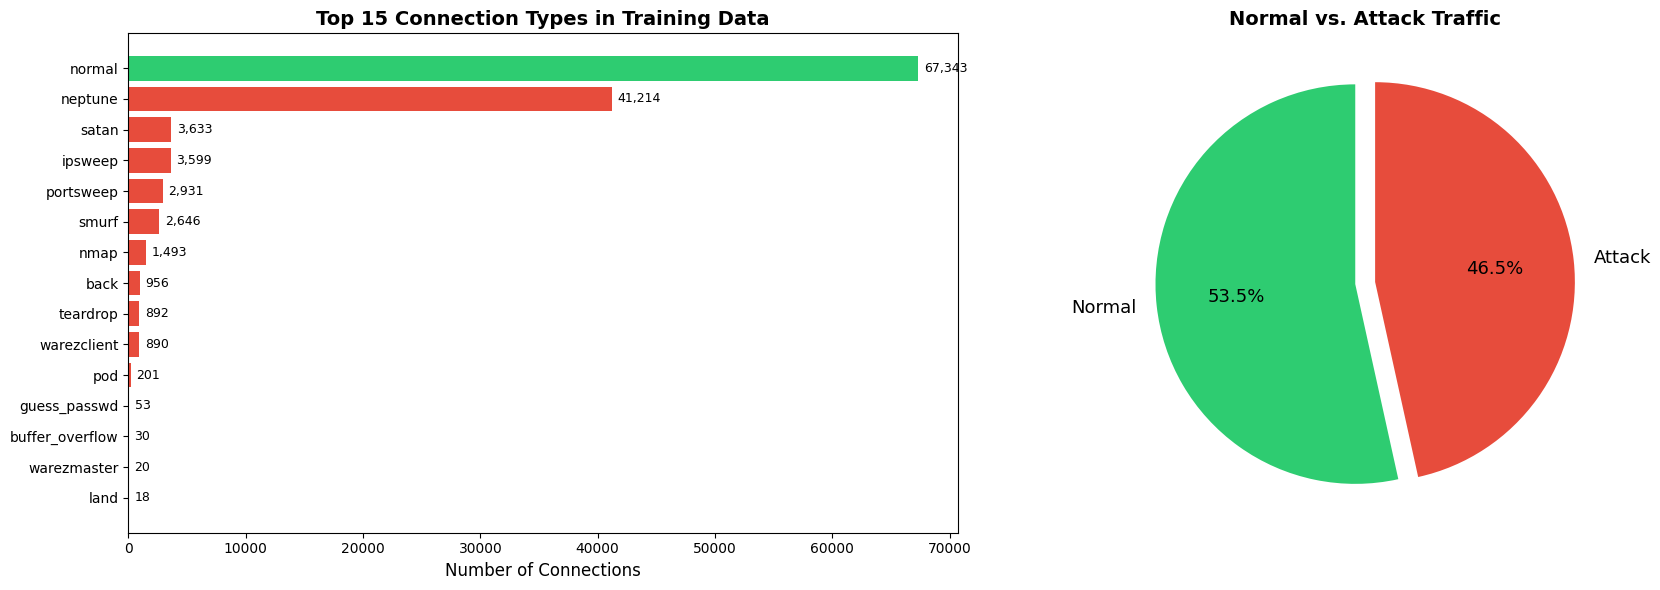


Normal connections: 67,343 (53.5%)
Attack connections: 58,630 (46.5%)


In [4]:
# =============================================================================
# STEP 2B: Target Variable Analysis — Attack Label Distribution
# =============================================================================
# This is the MOST IMPORTANT step in EDA for a classification problem.
# We need to understand:
#   - How many unique attack types exist?
#   - How severely imbalanced are the classes?
#   - Which attacks are rare (these are hardest to detect and most dangerous)
# =============================================================================

print("=" * 60)
print("  SECTION 3: TARGET VARIABLE — ATTACK LABEL DISTRIBUTION")
print("=" * 60)

# Count each label
label_counts = df_train['label'].value_counts()
print(f"\nNumber of unique labels: {label_counts.shape[0]}\n")
print(label_counts)

# --- Visualization: Attack Type Distribution ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Top 15 attack types (bar chart)
top_labels = label_counts.head(15)
colors = ['#2ecc71' if label == 'normal' else '#e74c3c' for label in top_labels.index]
axes[0].barh(top_labels.index[::-1], top_labels.values[::-1], color=colors[::-1])
axes[0].set_xlabel('Number of Connections', fontsize=12)
axes[0].set_title('Top 15 Connection Types in Training Data', fontsize=14, fontweight='bold')
for i, v in enumerate(top_labels.values[::-1]):
    axes[0].text(v + 500, i, f'{v:,}', va='center', fontsize=9)

# Plot 2: Normal vs. Attack (pie chart)
normal_count = label_counts.get('normal', 0)
attack_count = label_counts.sum() - normal_count
axes[1].pie(
    [normal_count, attack_count],
    labels=['Normal', 'Attack'],
    autopct='%1.1f%%',
    colors=['#2ecc71', '#e74c3c'],
    explode=(0.05, 0.05),
    textprops={'fontsize': 13},
    startangle=90
)
axes[1].set_title('Normal vs. Attack Traffic', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print the ratio
print(f"\nNormal connections: {normal_count:,} ({normal_count/len(df_train)*100:.1f}%)")
print(f"Attack connections: {attack_count:,} ({attack_count/len(df_train)*100:.1f}%)")

Unmapped labels in train: 0
Unmapped labels in test:  0

  5-CLASS ATTACK CATEGORY DISTRIBUTION (Training Set)
attack_category
Normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


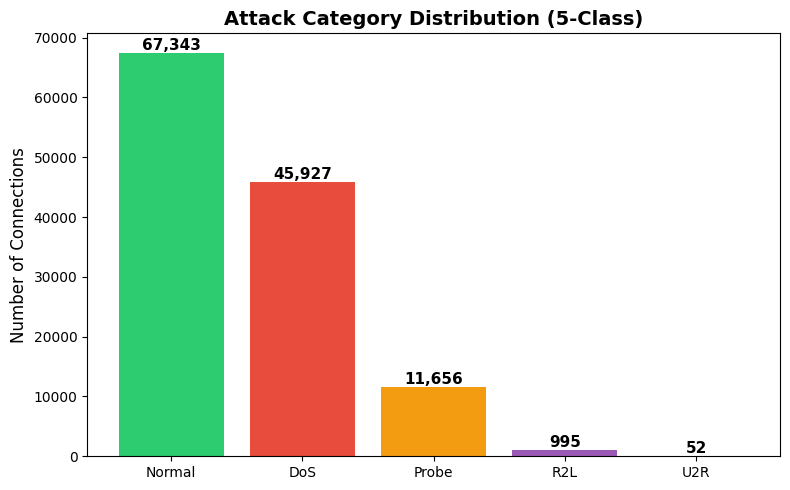


>>> KEY INSIGHT: U2R has only 52 samples — 
    this is a SEVERE class imbalance we must handle in Phase 4.


In [5]:
# =============================================================================
# STEP 2C: Map Attack Types to Their 5 Major Categories
# =============================================================================
# In cybersecurity, individual attack names are grouped into categories.
# This mapping is standard in NSL-KDD literature. We'll create BOTH:
#   - A binary label:       normal vs. attack
#   - A multi-class label:  normal, DoS, Probe, R2L, U2R
# This gives us flexibility later in modeling.
# =============================================================================

# Standard NSL-KDD attack-to-category mapping
attack_mapping = {
    'normal': 'Normal',
    # --- DoS (Denial of Service): Flood the target, crash it ---
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS',
    'smurf': 'DoS', 'teardrop': 'DoS', 'apache2': 'DoS', 'udpstorm': 'DoS',
    'processtable': 'DoS', 'mailbomb': 'DoS',
    # --- Probe (Surveillance/Scanning): Map the network ---
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe',
    'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    # --- R2L (Remote-to-Local): Gain unauthorized access remotely ---
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L',
    'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L',
    'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L',
    'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L',
    'sendmail': 'R2L', 'named': 'R2L', 'worm': 'R2L',
    # --- U2R (User-to-Root): Escalate privileges ---
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R',
    'perl': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R',
}

# Apply the mapping to both train and test sets
df_train['attack_category'] = df_train['label'].map(attack_mapping)
df_test['attack_category']  = df_test['label'].map(attack_mapping)

# Binary label: 0 = Normal, 1 = Attack
df_train['is_attack'] = (df_train['attack_category'] != 'Normal').astype(int)
df_test['is_attack']  = (df_test['attack_category'] != 'Normal').astype(int)

# Check for any unmapped labels (would show as NaN)
unmapped_train = df_train['attack_category'].isnull().sum()
unmapped_test  = df_test['attack_category'].isnull().sum()
print(f"Unmapped labels in train: {unmapped_train}")
print(f"Unmapped labels in test:  {unmapped_test}")

# Show the 5-class distribution
print("\n" + "=" * 60)
print("  5-CLASS ATTACK CATEGORY DISTRIBUTION (Training Set)")
print("=" * 60)
cat_counts = df_train['attack_category'].value_counts()
print(cat_counts)

# Visualize
fig, ax = plt.subplots(figsize=(8, 5))
cat_colors = {'Normal': '#2ecc71', 'DoS': '#e74c3c', 'Probe': '#f39c12',
              'R2L': '#9b59b6', 'U2R': '#3498db'}
bars = ax.bar(cat_counts.index, cat_counts.values,
              color=[cat_colors.get(c, '#95a5a6') for c in cat_counts.index])
ax.set_title('Attack Category Distribution (5-Class)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Connections', fontsize=12)

# Add count labels on top of each bar
for bar, val in zip(bars, cat_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
            f'{val:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n>>> KEY INSIGHT: U2R has only {cat_counts.get('U2R', 0)} samples — ")
print(f"    this is a SEVERE class imbalance we must handle in Phase 4.")

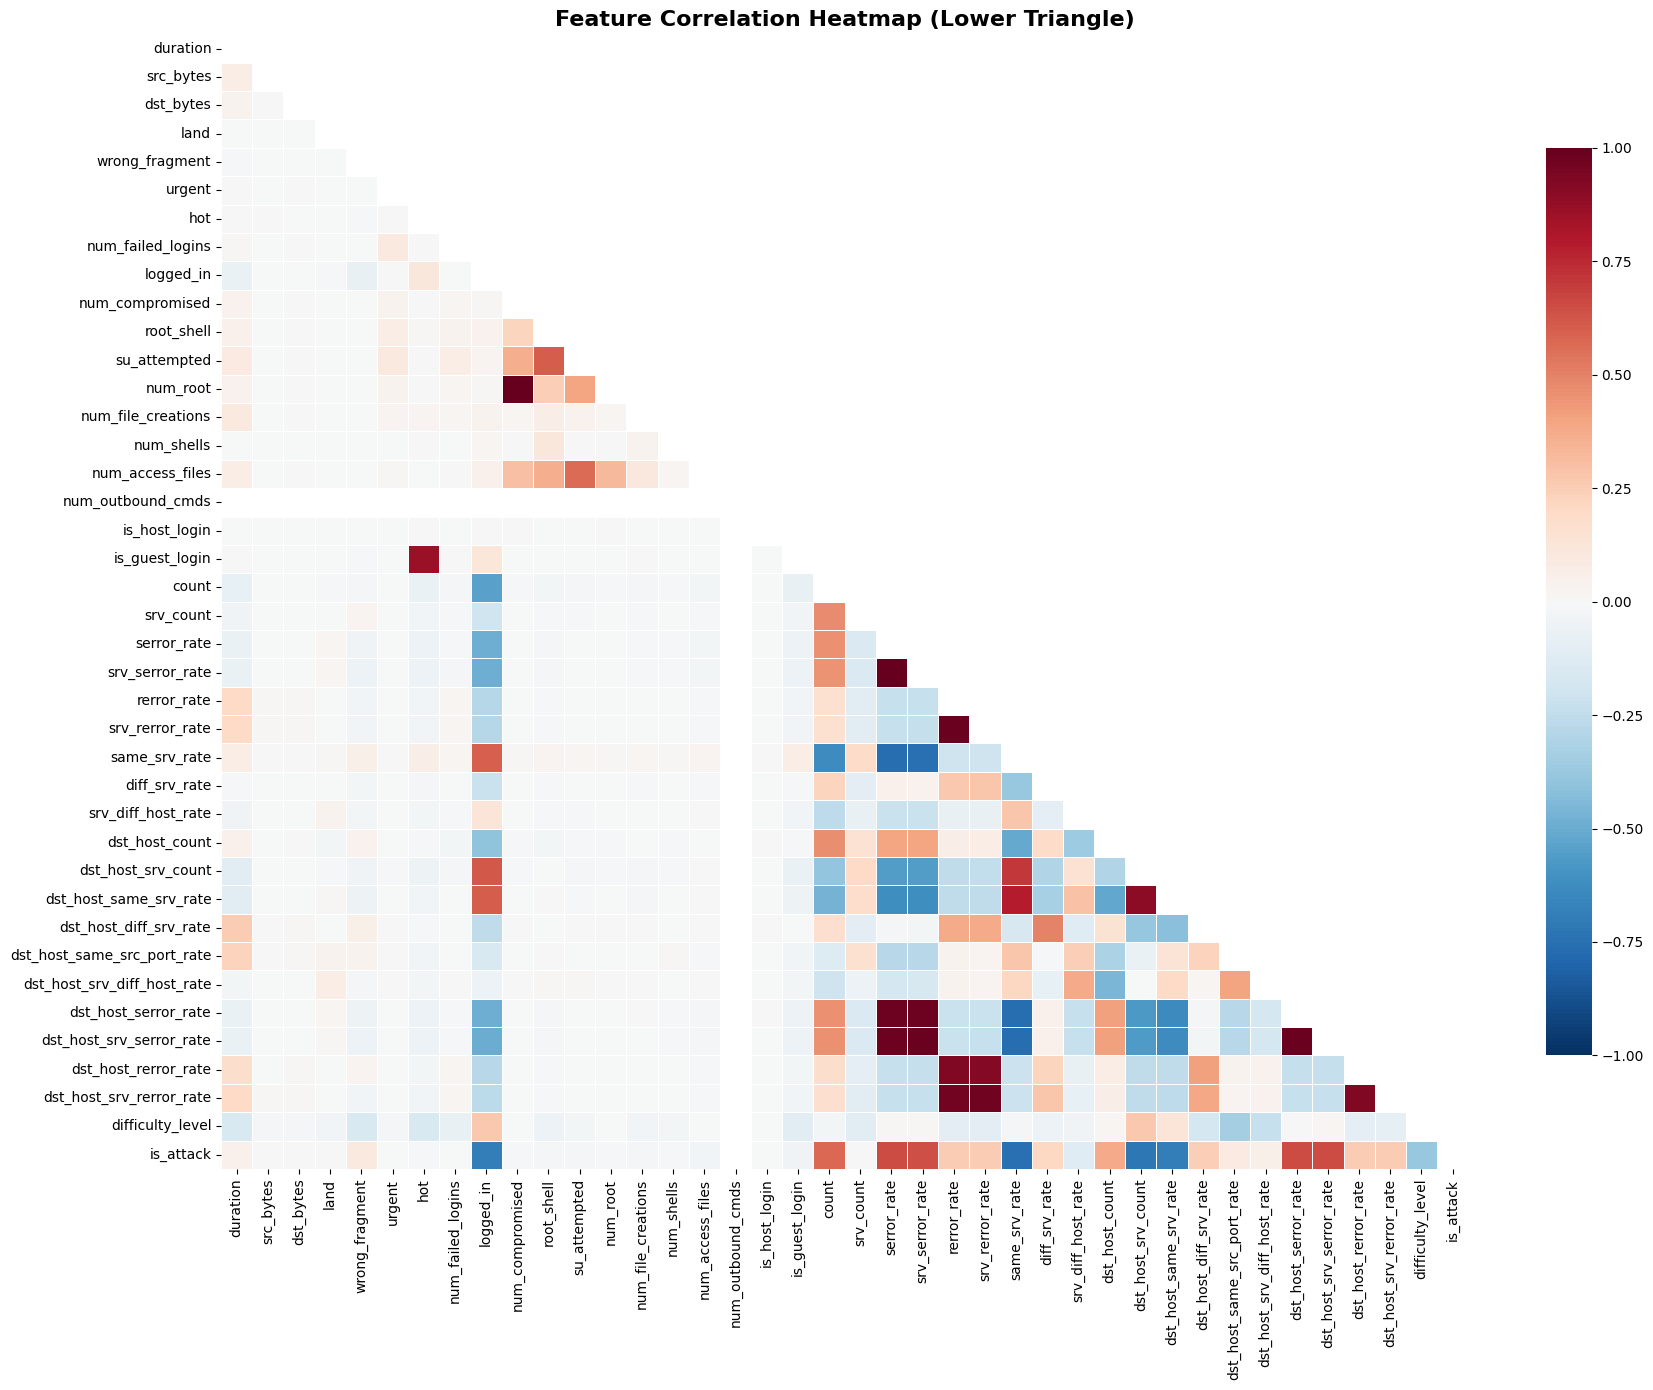

  TOP 15 MOST CORRELATED FEATURE PAIRS
   1. num_compromised                <-> num_root                       | r = 0.999
   2. srv_serror_rate                <-> serror_rate                    | r = 0.993
   3. rerror_rate                    <-> srv_rerror_rate                | r = 0.989
   4. dst_host_srv_serror_rate       <-> srv_serror_rate                | r = 0.986
   5. dst_host_srv_serror_rate       <-> dst_host_serror_rate           | r = 0.985
   6. dst_host_srv_serror_rate       <-> serror_rate                    | r = 0.981
   7. serror_rate                    <-> dst_host_serror_rate           | r = 0.979
   8. dst_host_serror_rate           <-> srv_serror_rate                | r = 0.978
   9. srv_rerror_rate                <-> dst_host_srv_rerror_rate       | r = 0.970
  10. rerror_rate                    <-> dst_host_srv_rerror_rate       | r = 0.964
  11. dst_host_rerror_rate           <-> rerror_rate                    | r = 0.927
  12. dst_host_srv_rerror_rate       

In [6]:
# =============================================================================
# STEP 3A: Feature Correlation Analysis
# =============================================================================
# We want to find:
#   1. Which features are highly correlated with each other (redundancy)
#   2. Which features correlate most strongly with the target (predictive power)
# This informs feature selection and engineering decisions.
# =============================================================================

# Compute correlation matrix on numeric features only
numeric_df = df_train.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# --- Plot 1: Full Correlation Heatmap ---
fig, ax = plt.subplots(figsize=(18, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='RdBu_r',        # Red = positive, Blue = negative
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    ax=ax,
    cbar_kws={'shrink': 0.8}
)
ax.set_title('Feature Correlation Heatmap (Lower Triangle)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Find the top correlated feature pairs (excluding self-correlation) ---
print("=" * 60)
print("  TOP 15 MOST CORRELATED FEATURE PAIRS")
print("=" * 60)

# Get upper triangle pairs
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1.0]  # Remove self-correlations
corr_pairs = corr_pairs.abs().sort_values(ascending=False)
# Drop duplicates (each pair appears twice)
seen = set()
unique_pairs = []
for (f1, f2), val in corr_pairs.items():
    pair_key = tuple(sorted([f1, f2]))
    if pair_key not in seen:
        seen.add(pair_key)
        unique_pairs.append((f1, f2, val))
    if len(unique_pairs) == 15:
        break

for i, (f1, f2, val) in enumerate(unique_pairs, 1):
    print(f"  {i:2d}. {f1:30s} <-> {f2:30s} | r = {val:.3f}")

  TOP 20 FEATURES CORRELATED WITH ATTACK LABEL
   1. same_srv_rate                       | 0.752 ██████████████████████████████
   2. dst_host_srv_count                  | 0.723 ████████████████████████████
   3. dst_host_same_srv_rate              | 0.694 ███████████████████████████
   4. logged_in                           | 0.690 ███████████████████████████
   5. dst_host_srv_serror_rate            | 0.655 ██████████████████████████
   6. dst_host_serror_rate                | 0.652 ██████████████████████████
   7. serror_rate                         | 0.651 ██████████████████████████
   8. srv_serror_rate                     | 0.648 █████████████████████████
   9. count                               | 0.576 ███████████████████████
  10. dst_host_count                      | 0.375 ███████████████
  11. srv_rerror_rate                     | 0.254 ██████████
  12. dst_host_srv_rerror_rate            | 0.253 ██████████
  13. rerror_rate                         | 0.253 ██████████
  14. d

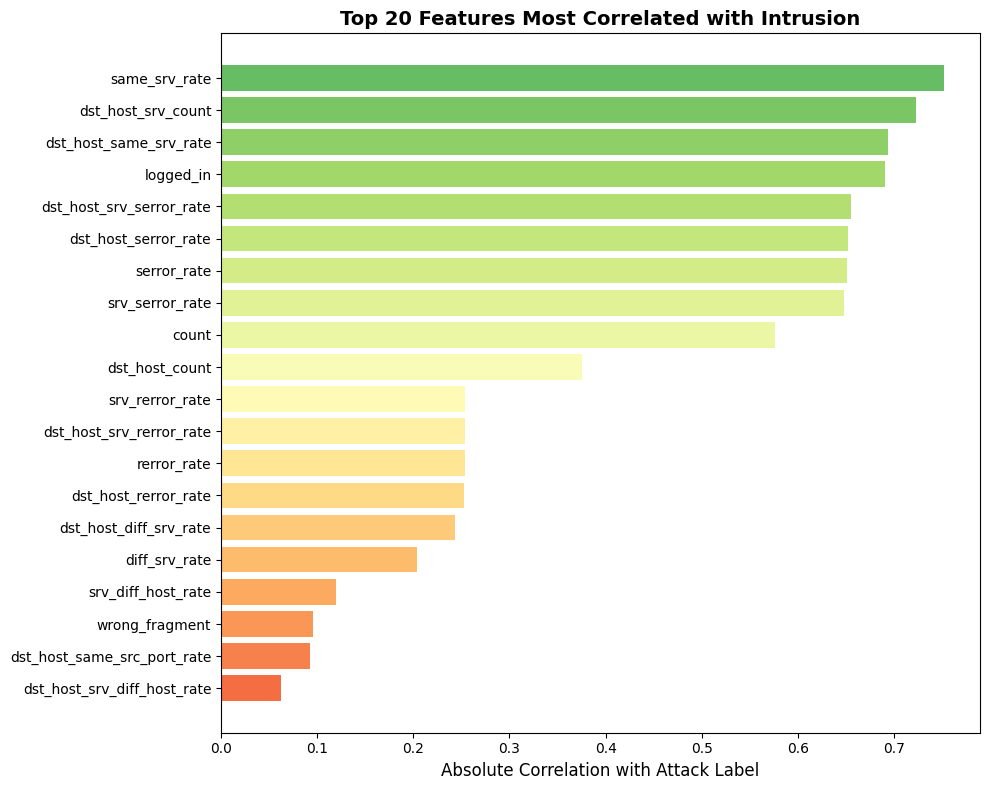

In [7]:
# =============================================================================
# STEP 3B: Feature Importance Preview — Correlation with Target
# =============================================================================
# Which features have the strongest linear relationship with is_attack?
# This is a QUICK screening tool, not definitive (XGBoost will capture
# non-linear relationships), but it tells us what's obviously useful.
# =============================================================================

# Correlation of each numeric feature with the binary target
target_corr = numeric_df.corrwith(df_train['is_attack']).abs().sort_values(ascending=False)

# Remove the target itself and difficulty_level (metadata, not a real feature)
target_corr = target_corr.drop(['is_attack', 'difficulty_level'], errors='ignore')

print("=" * 60)
print("  TOP 20 FEATURES CORRELATED WITH ATTACK LABEL")
print("=" * 60)
for i, (feat, val) in enumerate(target_corr.head(20).items(), 1):
    bar = '█' * int(val * 40)
    print(f"  {i:2d}. {feat:35s} | {val:.3f} {bar}")

# Visualize top 20
fig, ax = plt.subplots(figsize=(10, 8))
top20 = target_corr.head(20)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(top20)))
ax.barh(top20.index[::-1], top20.values[::-1], color=colors[::-1])
ax.set_xlabel('Absolute Correlation with Attack Label', fontsize=12)
ax.set_title('Top 20 Features Most Correlated with Intrusion', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

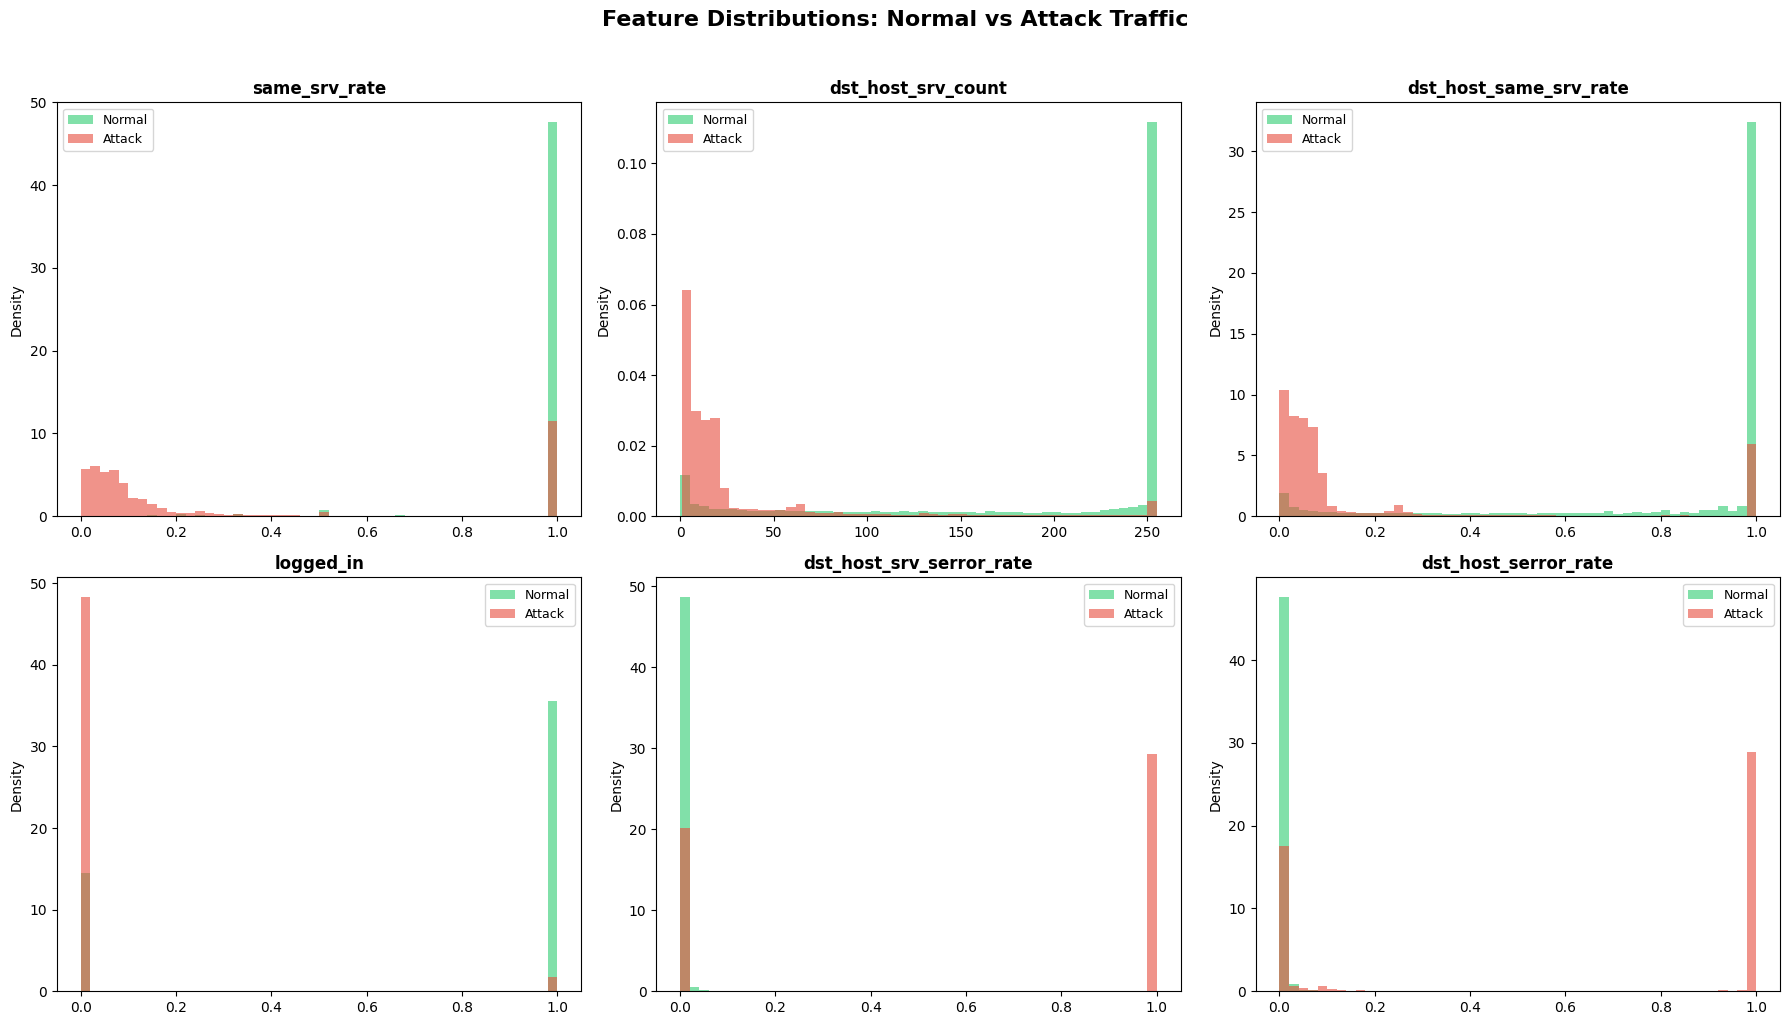

>>> EDA COMPLETE — We now understand our data's structure,
    class imbalance, feature correlations, and discriminative features.
    Next: Feature Engineering (Phase 3)


In [8]:
# =============================================================================
# STEP 3C: Distribution of Key Features — Normal vs Attack
# =============================================================================
# Visualize HOW the most important features differ between normal and
# attack traffic. This is the kind of plot that impresses in interviews
# because it shows you understand the DATA, not just the algorithms.
# =============================================================================

# Select the top 6 most correlated features for visualization
top_features = target_corr.head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_features):
    ax = axes[idx]

    # Separate normal and attack distributions
    normal_vals = df_train[df_train['is_attack'] == 0][feat]
    attack_vals = df_train[df_train['is_attack'] == 1][feat]

    # Use log scale if the feature has extreme outliers
    use_log = normal_vals.max() > 1000 or attack_vals.max() > 1000

    ax.hist(normal_vals, bins=50, alpha=0.6, label='Normal', color='#2ecc71',
            density=True, log=use_log)
    ax.hist(attack_vals, bins=50, alpha=0.6, label='Attack', color='#e74c3c',
            density=True, log=use_log)
    ax.set_title(f'{feat}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.set_ylabel('Density (log)' if use_log else 'Density')

fig.suptitle('Feature Distributions: Normal vs Attack Traffic', fontsize=16,
             fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(">>> EDA COMPLETE — We now understand our data's structure,")
print("    class imbalance, feature correlations, and discriminative features.")
print("    Next: Feature Engineering (Phase 3)")

In [9]:
# =============================================================================
# STEP 4A: Feature Engineering — Creating Domain-Informed Features
# =============================================================================
# A strong ML engineer doesn't just throw raw features into a model.
# We create NEW features based on domain knowledge of network security.
#
# Categories of engineered features:
#   1. Traffic volume ratios (bytes sent vs received)
#   2. Error rate aggregations (combining redundant error features)
#   3. Connection behavior flags (suspicious patterns)
#   4. Interaction features (feature combinations)
#   5. Log transforms (compress heavy-tailed distributions)
# =============================================================================

def engineer_features(df):
    """
    Apply all feature engineering transformations to a dataframe.
    This function is applied identically to train AND test sets
    to prevent data leakage and ensure consistency.
    """
    df = df.copy()  # Never modify the original

    # -----------------------------------------------------------------
    # 1. TRAFFIC VOLUME FEATURES
    # -----------------------------------------------------------------
    # Total bytes transferred in the connection
    df['total_bytes'] = df['src_bytes'] + df['dst_bytes']

    # Ratio of source-to-destination bytes
    # Intuition: Normal traffic has balanced send/receive (e.g., HTTP request/response).
    #            Attacks like DoS floods send massive data with little response.
    df['src_dst_byte_ratio'] = df['src_bytes'] / (df['dst_bytes'] + 1)  # +1 avoids division by zero

    # Log-transform of bytes (compresses extreme outliers)
    df['log_src_bytes'] = np.log1p(df['src_bytes'])
    df['log_dst_bytes'] = np.log1p(df['dst_bytes'])
    df['log_total_bytes'] = np.log1p(df['total_bytes'])

    # -----------------------------------------------------------------
    # 2. ERROR RATE AGGREGATIONS
    # -----------------------------------------------------------------
    # We saw that serror_rate, srv_serror_rate, dst_host_serror_rate,
    # dst_host_srv_serror_rate are all highly correlated (r > 0.95).
    # Instead of keeping all 4, we create a SINGLE composite error score.
    df['serror_composite'] = (
        df['serror_rate'] + df['srv_serror_rate'] +
        df['dst_host_serror_rate'] + df['dst_host_srv_serror_rate']
    ) / 4

    df['rerror_composite'] = (
        df['rerror_rate'] + df['srv_rerror_rate'] +
        df['dst_host_rerror_rate'] + df['dst_host_srv_rerror_rate']
    ) / 4

    # -----------------------------------------------------------------
    # 3. CONNECTION BEHAVIOR FLAGS
    # -----------------------------------------------------------------
    # Flag: Is there ANY error activity? (binary signal)
    df['has_serror'] = (df['serror_composite'] > 0).astype(int)
    df['has_rerror'] = (df['rerror_composite'] > 0).astype(int)

    # Flag: Zero bytes transferred (suspicious — could be a scan/probe)
    df['zero_src_bytes'] = (df['src_bytes'] == 0).astype(int)
    df['zero_dst_bytes'] = (df['dst_bytes'] == 0).astype(int)

    # Flag: Connection has compromised indicators
    df['has_compromise_indicators'] = (
        (df['num_compromised'] > 0) |
        (df['root_shell'] > 0) |
        (df['su_attempted'] > 0) |
        (df['num_root'] > 0)
    ).astype(int)

    # -----------------------------------------------------------------
    # 4. INTERACTION FEATURES
    # -----------------------------------------------------------------
    # Same-service rate * count — captures high-volume same-service patterns
    # (characteristic of DoS attacks targeting a single service)
    df['same_srv_rate_x_count'] = df['same_srv_rate'] * df['count']

    # Destination host service diversity score
    df['dst_host_srv_diversity'] = (
        df['dst_host_same_srv_rate'] - df['dst_host_diff_srv_rate']
    )

    # Service concentration on destination host
    df['dst_host_concentration'] = (
        df['dst_host_srv_count'] / (df['dst_host_count'] + 1)
    )

    # -----------------------------------------------------------------
    # 5. COUNT-BASED RATIOS
    # -----------------------------------------------------------------
    # Ratio of service connections to total connections
    df['srv_count_ratio'] = df['srv_count'] / (df['count'] + 1)

    return df


# Apply feature engineering to BOTH train and test sets
print("[1/2] Engineering features for training set...")
df_train = engineer_features(df_train)
print(f"      New shape: {df_train.shape}")

print("[2/2] Engineering features for test set...")
df_test = engineer_features(df_test)
print(f"      New shape: {df_test.shape}")

# Show the new features we created
original_cols = 43  # Original + label + difficulty
new_features = [c for c in df_train.columns if c not in columns + ['attack_category', 'is_attack']]
print(f"\n{'=' * 60}")
print(f"  FEATURE ENGINEERING COMPLETE")
print(f"{'=' * 60}")
print(f"  Original features:  {original_cols}")
print(f"  New features added: {len(new_features)}")
print(f"  Total columns now:  {df_train.shape[1]}")
print(f"\n  New features created:")
for i, f in enumerate(new_features, 1):
    print(f"    {i:2d}. {f}")

[1/2] Engineering features for training set...
      New shape: (125973, 61)
[2/2] Engineering features for test set...
      New shape: (22544, 61)

  FEATURE ENGINEERING COMPLETE
  Original features:  43
  New features added: 16
  Total columns now:  61

  New features created:
     1. total_bytes
     2. src_dst_byte_ratio
     3. log_src_bytes
     4. log_dst_bytes
     5. log_total_bytes
     6. serror_composite
     7. rerror_composite
     8. has_serror
     9. has_rerror
    10. zero_src_bytes
    11. zero_dst_bytes
    12. has_compromise_indicators
    13. same_srv_rate_x_count
    14. dst_host_srv_diversity
    15. dst_host_concentration
    16. srv_count_ratio


  ENGINEERED FEATURE CORRELATION WITH ATTACK LABEL
  ★ zero_dst_bytes                      | 0.810 ████████████████████████████████
  ★ log_total_bytes                     | 0.783 ███████████████████████████████
  ★ log_dst_bytes                       | 0.753 ██████████████████████████████
  ★ zero_src_bytes                      | 0.749 █████████████████████████████
  ★ log_src_bytes                       | 0.729 █████████████████████████████
  ★ serror_composite                    | 0.655 ██████████████████████████
  ★ dst_host_srv_diversity              | 0.644 █████████████████████████
  ★ has_serror                          | 0.541 █████████████████████
    rerror_composite                    | 0.258 ██████████
    has_rerror                          | 0.178 ███████
    dst_host_concentration              | 0.131 █████
    srv_count_ratio                     | 0.036 █
    same_srv_rate_x_count               | 0.030 █
    has_compromise_indicators           | 0.009 
    total_bytes 

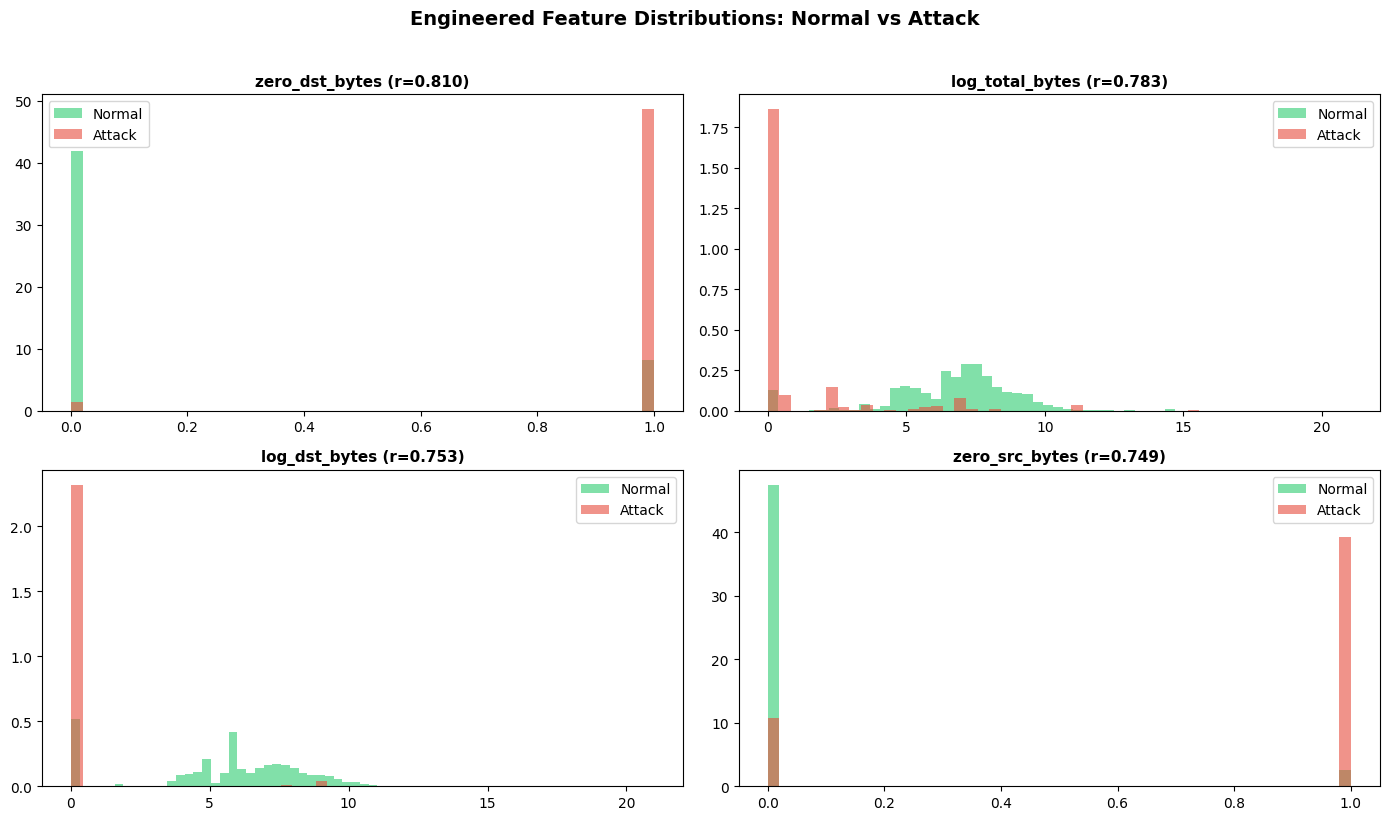


>>> Feature Engineering validated. New features show strong signal.
    Next: Preprocessing Pipeline (encoding, scaling, train/test split)


In [10]:
# =============================================================================
# STEP 4B: Validate Engineered Features — Quick Sanity Check
# =============================================================================
# Verify our new features make sense by checking their distributions
# and correlation with the target.
# =============================================================================

# Check correlation of NEW features with attack label
new_feat_corr = df_train[new_features].corrwith(df_train['is_attack']).abs().sort_values(ascending=False)

print("=" * 60)
print("  ENGINEERED FEATURE CORRELATION WITH ATTACK LABEL")
print("=" * 60)
for feat, val in new_feat_corr.items():
    bar = '█' * int(val * 40)
    indicator = "★" if val > 0.3 else " "
    print(f"  {indicator} {feat:35s} | {val:.3f} {bar}")

print(f"\n  ★ = Strong signal (correlation > 0.3)")

# Quick distribution check on the top 4 new features
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
top_new = new_feat_corr.head(4).index.tolist()

for idx, feat in enumerate(top_new):
    ax = axes[idx]
    normal_vals = df_train[df_train['is_attack'] == 0][feat]
    attack_vals = df_train[df_train['is_attack'] == 1][feat]

    ax.hist(normal_vals, bins=50, alpha=0.6, label='Normal', color='#2ecc71', density=True)
    ax.hist(attack_vals, bins=50, alpha=0.6, label='Attack', color='#e74c3c', density=True)
    ax.set_title(f'{feat} (r={new_feat_corr[feat]:.3f})', fontsize=11, fontweight='bold')
    ax.legend()

fig.suptitle('Engineered Feature Distributions: Normal vs Attack',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n>>> Feature Engineering validated. New features show strong signal.")
print("    Next: Preprocessing Pipeline (encoding, scaling, train/test split)")

In [11]:
# =============================================================================
# STEP 5A: Prepare Feature Matrix — Drop Metadata, Encode Categoricals
# =============================================================================
# We need to:
#   1. Drop non-feature columns (labels, metadata, difficulty_level)
#   2. Encode categorical columns (protocol_type, service, flag)
#   3. Scale numeric features
#   4. Prepare X (features) and y (target) for both train and test
#
# IMPORTANT DESIGN DECISION:
#   We will model the 5-CLASS problem (Normal, DoS, Probe, R2L, U2R).
#   This is harder than binary classification and far more impressive
#   on a resume — it shows you can handle multi-class imbalanced problems.
# =============================================================================

# Columns to DROP (not features — they're labels or metadata)
drop_cols = ['label', 'difficulty_level', 'attack_category', 'is_attack']

# Define our target: the 5-class attack category
# Encode it as integers for the model
target_encoder = LabelEncoder()
y_train = target_encoder.fit_transform(df_train['attack_category'])
y_test  = target_encoder.transform(df_test['attack_category'])

print("Target classes and their encoded values:")
for i, cls in enumerate(target_encoder.classes_):
    count_train = (y_train == i).sum()
    print(f"  {i} = {cls:8s} | Train samples: {count_train:,}")

# Separate features
X_train = df_train.drop(columns=drop_cols)
X_test  = df_test.drop(columns=drop_cols)

# --- Encode Categorical Features ---
# protocol_type: tcp, udp, icmp (3 values)
# service: http, ftp, smtp, etc. (70 values)
# flag: SF, S0, REJ, etc. (11 values)
#
# Strategy: Label Encoding for tree-based models (XGBoost handles this natively).
# We do NOT need one-hot encoding — trees split on thresholds, not magnitudes.

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on COMBINED train + test to handle unseen categories
    combined = pd.concat([X_train[col], X_test[col]], axis=0)
    le.fit(combined)
    X_train[col] = le.transform(X_train[col])
    X_test[col]  = le.transform(X_test[col])
    label_encoders[col] = le
    print(f"\n  Encoded '{col}': {le.classes_.shape[0]} unique values")
    print(f"    Examples: {list(le.classes_[:5])}...")

print(f"\n{'=' * 60}")
print(f"  FEATURE MATRIX READY")
print(f"{'=' * 60}")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape:  {X_test.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_test shape:  {y_test.shape}")
print(f"  All dtypes numeric: {X_train.select_dtypes(include=['object']).shape[1] == 0}")

Target classes and their encoded values:
  0 = DoS      | Train samples: 45,927
  1 = Normal   | Train samples: 67,343
  2 = Probe    | Train samples: 11,656
  3 = R2L      | Train samples: 995
  4 = U2R      | Train samples: 52

  Encoded 'protocol_type': 3 unique values
    Examples: ['icmp', 'tcp', 'udp']...

  Encoded 'service': 70 unique values
    Examples: ['IRC', 'X11', 'Z39_50', 'aol', 'auth']...

  Encoded 'flag': 11 unique values
    Examples: ['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR']...

  FEATURE MATRIX READY
  X_train shape: (125973, 57)
  X_test shape:  (22544, 57)
  y_train shape: (125973,)
  y_test shape:  (22544,)
  All dtypes numeric: True


In [12]:
# =============================================================================
# STEP 5B: Feature Scaling with StandardScaler
# =============================================================================
# Although XGBoost doesn't strictly require scaling (it's tree-based),
# we scale anyway because:
#   1. Our baseline Random Forest comparison benefits from it
#   2. SHAP values are more interpretable on standardized features
#   3. It's best practice in production pipelines
#
# CRITICAL: We fit the scaler on TRAINING data only, then transform both.
# Fitting on test data would be DATA LEAKAGE — a disqualifying mistake
# in any ML interview.
# =============================================================================

scaler = StandardScaler()

# Store feature names before scaling (numpy arrays lose column names)
feature_names = X_train.columns.tolist()

# Fit on train, transform both
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)    # NOTE: transform only, NOT fit_transform

# Convert back to DataFrames (keeps feature names for SHAP later)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=feature_names)

print("=" * 60)
print("  SCALING COMPLETE")
print("=" * 60)
print(f"  Scaler fitted on training data only (no data leakage)")
print(f"  X_train_scaled shape: {X_train_scaled.shape}")
print(f"  X_test_scaled shape:  {X_test_scaled.shape}")

# Verify scaling worked: means should be ~0, stds should be ~1 on train
print(f"\n  Train mean (should be ~0): {X_train_scaled.mean().mean():.6f}")
print(f"  Train std  (should be ~1): {X_train_scaled.std().mean():.4f}")
print(f"  Test mean  (will differ):  {X_test_scaled.mean().mean():.4f}")
print(f"  Test std   (will differ):  {X_test_scaled.std().mean():.4f}")

print(f"\n>>> Preprocessing pipeline complete.")
print(f"    {len(feature_names)} features ready for modeling.")
print(f"    Next: Handle class imbalance, then train models!")

  SCALING COMPLETE
  Scaler fitted on training data only (no data leakage)
  X_train_scaled shape: (125973, 57)
  X_test_scaled shape:  (22544, 57)

  Train mean (should be ~0): -0.000000
  Train std  (should be ~1): 0.9825
  Test mean  (will differ):  0.0357
  Test std   (will differ):  1.0935

>>> Preprocessing pipeline complete.
    57 features ready for modeling.
    Next: Handle class imbalance, then train models!


In [13]:
# =============================================================================
# STEP 6A: Handle Class Imbalance with SMOTE
# =============================================================================
# Problem: U2R has 52 samples, R2L has 995, while Normal has 67,343.
# A model that predicts "Normal" for everything would get 53% accuracy
# but miss EVERY dangerous attack. This is unacceptable in cybersecurity.
#
# Solution: SMOTE (Synthetic Minority Oversampling Technique)
# - Generates synthetic samples for minority classes
# - Works by interpolating between existing minority samples and their
#   nearest neighbors in feature space
#
# IMPORTANT: We apply SMOTE to TRAINING data only. The test set must
# remain untouched to simulate real-world evaluation.
# =============================================================================

!pip install imbalanced-learn --quiet

from imblearn.over_sampling import SMOTE
from collections import Counter

print("BEFORE SMOTE — Training class distribution:")
print("-" * 45)
before_counts = Counter(y_train)
for cls_idx in sorted(before_counts.keys()):
    cls_name = target_encoder.classes_[cls_idx]
    count = before_counts[cls_idx]
    bar = '█' * int(count / 2000)
    print(f"  {cls_name:8s} (class {cls_idx}): {count:>6,}  {bar}")

# Apply SMOTE
# We use a custom sampling strategy: bring minority classes up, but not
# all the way to the majority class size (that would create too many
# synthetic samples and hurt generalization).
smote = SMOTE(
    sampling_strategy={
        0: 45927,   # DoS    — already large, keep as is
        1: 67343,   # Normal — majority class, keep as is
        2: 11656,   # Probe  — already decent, keep as is
        3: 8000,    # R2L    — oversample from 995 → 8,000
        4: 4000,    # U2R    — oversample from 52 → 4,000
    },
    random_state=42,
    k_neighbors=3     # Use 3 neighbors (fewer for very small classes)
)

print("\nApplying SMOTE (this may take a moment)...")
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("\nAFTER SMOTE — Training class distribution:")
print("-" * 45)
after_counts = Counter(y_train_resampled)
for cls_idx in sorted(after_counts.keys()):
    cls_name = target_encoder.classes_[cls_idx]
    before = before_counts[cls_idx]
    after = after_counts[cls_idx]
    change = after - before
    print(f"  {cls_name:8s}: {before:>6,} → {after:>6,}  (+{change:,} synthetic)")

print(f"\nTotal training samples: {len(y_train_resampled):,}")
print(f">>> Class imbalance addressed. R2L and U2R now have enough")
print(f"    representation for the model to learn their patterns.")

BEFORE SMOTE — Training class distribution:
---------------------------------------------
  DoS      (class 0): 45,927  ██████████████████████
  Normal   (class 1): 67,343  █████████████████████████████████
  Probe    (class 2): 11,656  █████
  R2L      (class 3):    995  
  U2R      (class 4):     52  

Applying SMOTE (this may take a moment)...

AFTER SMOTE — Training class distribution:
---------------------------------------------
  DoS     : 45,927 → 45,927  (+0 synthetic)
  Normal  : 67,343 → 67,343  (+0 synthetic)
  Probe   : 11,656 → 11,656  (+0 synthetic)
  R2L     :    995 →  8,000  (+7,005 synthetic)
  U2R     :     52 →  4,000  (+3,948 synthetic)

Total training samples: 136,926
>>> Class imbalance addressed. R2L and U2R now have enough
    representation for the model to learn their patterns.


In [14]:
# =============================================================================
# STEP 6B: Baseline Model — Random Forest Classifier
# =============================================================================
# Why start with Random Forest?
#   1. It's fast, robust, and requires minimal tuning
#   2. It establishes a performance BASELINE to beat with XGBoost
#   3. Showing baseline → optimized model improvement is a powerful
#      story on a resume ("Improved F1 from X to Y via...")
#
# We train on the SMOTE-resampled data, evaluate on the ORIGINAL test set.
# =============================================================================
from sklearn.metrics import classification_report, confusion_matrix
import time

print("=" * 60)
print("  TRAINING BASELINE: Random Forest Classifier")
print("=" * 60)

# Train
start = time.time()
rf_model = RandomForestClassifier(
    n_estimators=200,       # 200 trees in the forest
    max_depth=25,           # Limit depth to prevent overfitting
    min_samples_split=5,    # Minimum samples to split a node
    min_samples_leaf=2,     # Minimum samples in a leaf
    class_weight='balanced',# Additional class weight balancing
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)
rf_model.fit(X_train_resampled, y_train_resampled)
train_time = time.time() - start
print(f"  Training time: {train_time:.1f} seconds")

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# --- Classification Report ---
print(f"\n{'=' * 60}")
print(f"  BASELINE RESULTS: Random Forest on Test Set")
print(f"{'=' * 60}")
print(classification_report(
    y_test, y_pred_rf,
    target_names=target_encoder.classes_,
    digits=4
))

# Overall accuracy
acc = accuracy_score(y_test, y_pred_rf)
f1_macro = f1_score(y_test, y_pred_rf, average='macro')
f1_weighted = f1_score(y_test, y_pred_rf, average='weighted')
print(f"  Overall Accuracy:  {acc:.4f}")
print(f"  Macro F1 Score:    {f1_macro:.4f}  ← treats all classes equally")
print(f"  Weighted F1 Score: {f1_weighted:.4f}")

  TRAINING BASELINE: Random Forest Classifier
  Training time: 67.2 seconds

  BASELINE RESULTS: Random Forest on Test Set
              precision    recall  f1-score   support

         DoS     0.9601    0.7713    0.8554      7458
      Normal     0.6412    0.9708    0.7723      9711
       Probe     0.8181    0.6130    0.7008      2421
         R2L     0.7368    0.0048    0.0096      2887
         U2R     0.6316    0.1791    0.2791        67

    accuracy                         0.7403     22544
   macro avg     0.7576    0.5078    0.5234     22544
weighted avg     0.7779    0.7403    0.6930     22544

  Overall Accuracy:  0.7403
  Macro F1 Score:    0.5234  ← treats all classes equally
  Weighted F1 Score: 0.6930


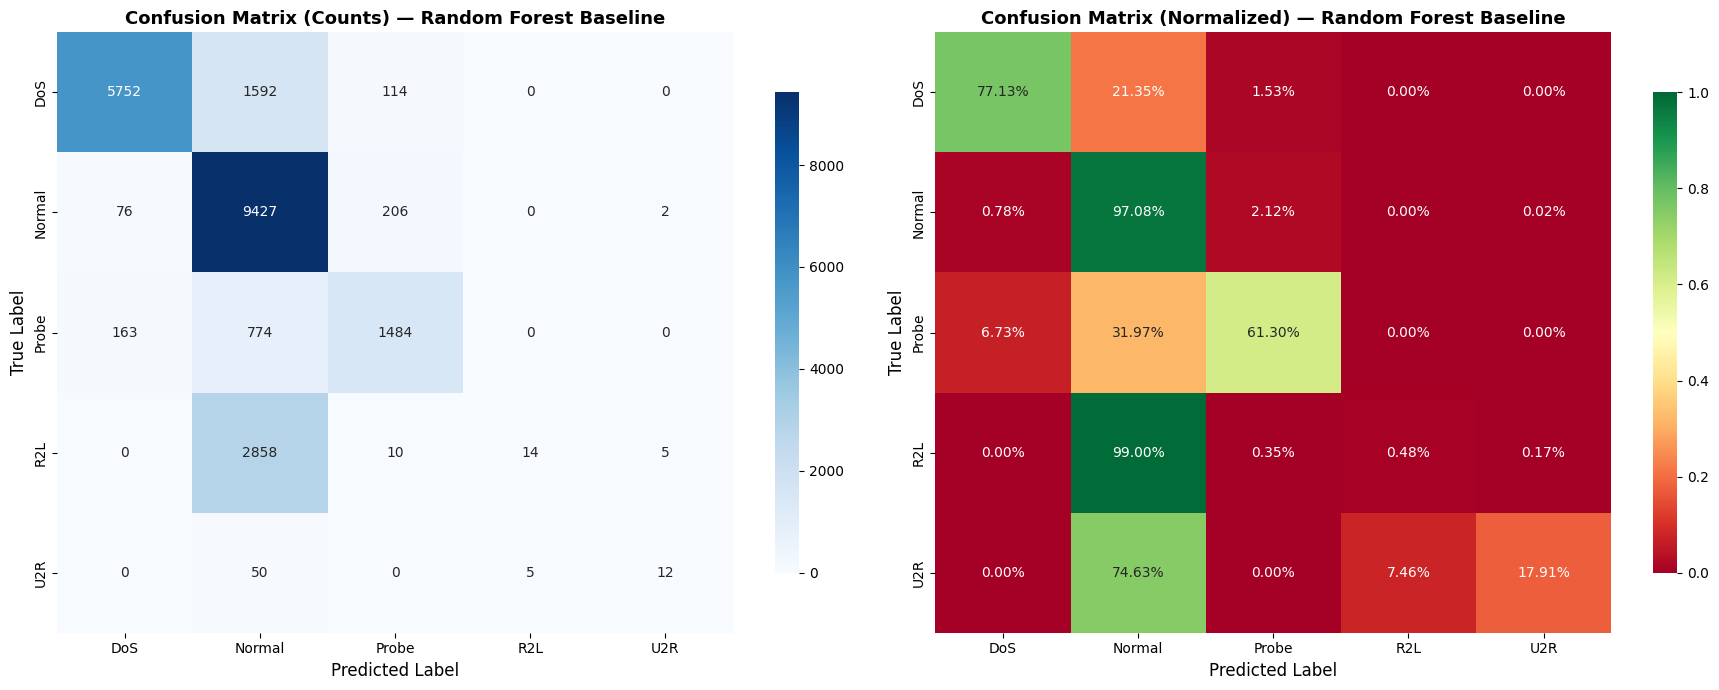

KEY OBSERVATIONS:
  ✓ DoS: 77.1% correctly classified
  ✓ Normal: 97.1% correctly classified
  ⚠ Probe: Only 61.3% correctly classified — needs improvement
  ⚠ R2L: Only 0.5% correctly classified — needs improvement
  ⚠ U2R: Only 17.9% correctly classified — needs improvement

>>> Baseline established. Next: XGBoost with hyperparameter tuning
    to beat these numbers.


In [15]:
# =============================================================================
# STEP 6C: Confusion Matrix — Baseline Random Forest
# =============================================================================
# The confusion matrix shows WHERE the model makes mistakes.
# In cybersecurity, False Negatives (missed attacks) are far more
# dangerous than False Positives (false alarms).
# =============================================================================

cm = confusion_matrix(y_test, y_pred_rf)
class_names = target_encoder.classes_

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix (Counts) — Random Forest Baseline', fontsize=13, fontweight='bold')

# Plot 2: Normalized (percentages per true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1], vmin=0, vmax=1, cbar_kws={'shrink': 0.8})
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Confusion Matrix (Normalized) — Random Forest Baseline', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Highlight the problem areas
print("KEY OBSERVATIONS:")
for i, cls in enumerate(class_names):
    correct = cm_normalized[i, i]
    if correct < 0.7:
        print(f"  ⚠ {cls}: Only {correct:.1%} correctly classified — needs improvement")
    else:
        print(f"  ✓ {cls}: {correct:.1%} correctly classified")

print(f"\n>>> Baseline established. Next: XGBoost with hyperparameter tuning")
print(f"    to beat these numbers.")

In [16]:
# =============================================================================
# STEP 7A: XGBoost + Optuna Hyperparameter Optimization
# =============================================================================
# Why XGBoost over Random Forest?
#   - Gradient boosting sequentially corrects errors from previous trees
#   - Better handling of class weights and imbalanced data
#   - Regularization (L1/L2) prevents overfitting
#   - Typically outperforms RF on structured/tabular data
#
# Why Optuna?
#   - State-of-the-art Bayesian hyperparameter optimization
#   - More efficient than GridSearch (doesn't try every combination)
#   - Uses Tree-structured Parzen Estimators (TPE) to intelligently
#     search the hyperparameter space
#   - Looks incredible on a resume
# =============================================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Suppress verbose logs

# Compute class weights for XGBoost (inverse frequency)
# This tells the model to pay MORE attention to rare classes
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train_resampled)

def objective(trial):
    """
    Optuna objective function. Each 'trial' is one hyperparameter configuration.
    Optuna will call this function ~50 times, each time with different params,
    and learn which regions of the search space produce the best results.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'objective': 'multi:softprob',
        'num_class': 5,
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',  # Fast histogram-based method
    }

    model = xgb.XGBClassifier(**params)

    # Use 3-fold stratified cross-validation for speed
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train_resampled, y_train_resampled,
        cv=cv,
        scoring='f1_macro',     # Optimize for MACRO F1 (treats all classes equally)
        fit_params={'sample_weight': sample_weights}
    )
    return scores.mean()

# Run the optimization
print("=" * 60)
print("  OPTUNA HYPERPARAMETER OPTIMIZATION")
print("=" * 60)
print("  Objective: Maximize Macro F1 Score (3-fold CV)")
print("  Trials: 40 (each tests a different configuration)")
print("  This will take 3-8 minutes...")
print("=" * 60)

study = optuna.create_study(direction='maximize', study_name='xgb_ids')
study.optimize(objective, n_trials=40, show_progress_bar=True)

# Results
print(f"\n{'=' * 60}")
print(f"  OPTIMIZATION COMPLETE")
print(f"{'=' * 60}")
print(f"  Best Macro F1 (CV): {study.best_value:.4f}")
print(f"  Best Parameters:")
for param, value in study.best_params.items():
    print(f"    {param:25s}: {value}")

  OPTUNA HYPERPARAMETER OPTIMIZATION
  Objective: Maximize Macro F1 Score (3-fold CV)
  Trials: 40 (each tests a different configuration)
  This will take 3-8 minutes...


  0%|          | 0/40 [00:00<?, ?it/s]

[W 2026-02-21 21:32:25,001] Trial 0 failed with parameters: {'n_estimators': 600, 'max_depth': 12, 'learning_rate': 0.09004484942899502, 'subsample': 0.6465454473160471, 'colsample_bytree': 0.9239028826504556, 'min_child_weight': 6, 'gamma': 2.261236888409553, 'reg_alpha': 0.0015008160291065833, 'reg_lambda': 0.00886619024794149} because of the following error: TypeError("got an unexpected keyword argument 'fit_params'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-1730130019.py", line 55, in objective
    scores = cross_val_score(
             ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_param_validation.py", line 194, in wrapper
    params = func_sig.bind(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/inspect.py", line 3280, 

TypeError: got an unexpected keyword argument 'fit_params'

In [17]:
# =============================================================================
# STEP 7A: XGBoost + Optuna Hyperparameter Optimization (FIXED)
# =============================================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# We'll apply sample weights during FINAL training only.
# For CV during Optuna, the SMOTE-balanced data + XGBoost's built-in
# class handling is sufficient.

def objective(trial):
    """
    Optuna objective function. Each 'trial' tests a different
    hyperparameter configuration. Optuna learns which regions of
    the search space produce the best results using Bayesian optimization.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800, step=100),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'objective': 'multi:softprob',
        'num_class': 5,
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    model = xgb.XGBClassifier(**params)

    # 3-fold stratified cross-validation on SMOTE-balanced data
    # No fit_params needed — data is already balanced by SMOTE
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train_resampled, y_train_resampled,
        cv=cv,
        scoring='f1_macro'  # Optimize for MACRO F1 (treats all classes equally)
    )
    return scores.mean()

# Run the optimization
print("=" * 60)
print("  OPTUNA HYPERPARAMETER OPTIMIZATION")
print("=" * 60)
print("  Objective: Maximize Macro F1 Score (3-fold CV)")
print("  Trials: 40 (each tests a different configuration)")
print("  This will take 3-8 minutes...")
print("=" * 60)

study = optuna.create_study(direction='maximize', study_name='xgb_ids')
study.optimize(objective, n_trials=40, show_progress_bar=True)

# Results
print(f"\n{'=' * 60}")
print(f"  OPTIMIZATION COMPLETE")
print(f"{'=' * 60}")
print(f"  Best Macro F1 (CV): {study.best_value:.4f}")
print(f"  Best Parameters:")
for param, value in study.best_params.items():
    print(f"    {param:25s}: {value}")

  OPTUNA HYPERPARAMETER OPTIMIZATION
  Objective: Maximize Macro F1 Score (3-fold CV)
  Trials: 40 (each tests a different configuration)
  This will take 3-8 minutes...


  0%|          | 0/40 [00:00<?, ?it/s]


  OPTIMIZATION COMPLETE
  Best Macro F1 (CV): 0.9986
  Best Parameters:
    n_estimators             : 300
    max_depth                : 12
    learning_rate            : 0.2666335900428979
    subsample                : 0.9790925067348618
    colsample_bytree         : 0.827944546482819
    min_child_weight         : 4
    gamma                    : 0.002313527874394762
    reg_alpha                : 0.010639850804652564
    reg_lambda               : 3.856403510941893


In [18]:
# =============================================================================
# STEP 7B: Train Final XGBoost Model with Optimized Hyperparameters
# =============================================================================
# Now we train on the FULL resampled training set (no CV splits)
# using the best parameters Optuna found.
# =============================================================================

best_params = study.best_params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': 5,
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist',
})

print("=" * 60)
print("  TRAINING FINAL XGBoost MODEL")
print("=" * 60)

start = time.time()
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(
    X_train_resampled,
    y_train_resampled,
    sample_weight=sample_weights,
    verbose=False
)
train_time_xgb = time.time() - start
print(f"  Training time: {train_time_xgb:.1f} seconds")

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# --- Full Classification Report ---
print(f"\n{'=' * 60}")
print(f"  OPTIMIZED XGBoost RESULTS on Test Set")
print(f"{'=' * 60}")
print(classification_report(
    y_test, y_pred_xgb,
    target_names=target_encoder.classes_,
    digits=4
))

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_macro_xgb = f1_score(y_test, y_pred_xgb, average='macro')
f1_weighted_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"  Overall Accuracy:  {acc_xgb:.4f}")
print(f"  Macro F1 Score:    {f1_macro_xgb:.4f}")
print(f"  Weighted F1 Score: {f1_weighted_xgb:.4f}")

# --- Comparison with Baseline ---
print(f"\n{'=' * 60}")
print(f"  IMPROVEMENT OVER BASELINE")
print(f"{'=' * 60}")
print(f"  {'Metric':<22s} {'Random Forest':>14s} {'XGBoost':>10s} {'Δ':>10s}")
print(f"  {'-'*56}")
print(f"  {'Accuracy':<22s} {acc:>14.4f} {acc_xgb:>10.4f} {acc_xgb - acc:>+10.4f}")
print(f"  {'Macro F1':<22s} {f1_macro:>14.4f} {f1_macro_xgb:>10.4f} {f1_macro_xgb - f1_macro:>+10.4f}")
print(f"  {'Weighted F1':<22s} {f1_weighted:>14.4f} {f1_weighted_xgb:>10.4f} {f1_weighted_xgb - f1_weighted:>+10.4f}")

  TRAINING FINAL XGBoost MODEL
  Training time: 75.7 seconds

  OPTIMIZED XGBoost RESULTS on Test Set
              precision    recall  f1-score   support

         DoS     0.9662    0.8382    0.8976      7458
      Normal     0.6972    0.9718    0.8119      9711
       Probe     0.8124    0.7385    0.7737      2421
         R2L     0.9739    0.1032    0.1867      2887
         U2R     0.6452    0.2985    0.4082        67

    accuracy                         0.7893     22544
   macro avg     0.8189    0.5900    0.6156     22544
weighted avg     0.8338    0.7893    0.7549     22544

  Overall Accuracy:  0.7893
  Macro F1 Score:    0.6156
  Weighted F1 Score: 0.7549

  IMPROVEMENT OVER BASELINE
  Metric                  Random Forest    XGBoost          Δ
  --------------------------------------------------------
  Accuracy                       0.7403     0.7893    +0.0490
  Macro F1                       0.5234     0.6156    +0.0922
  Weighted F1                    0.6930     0.7549 

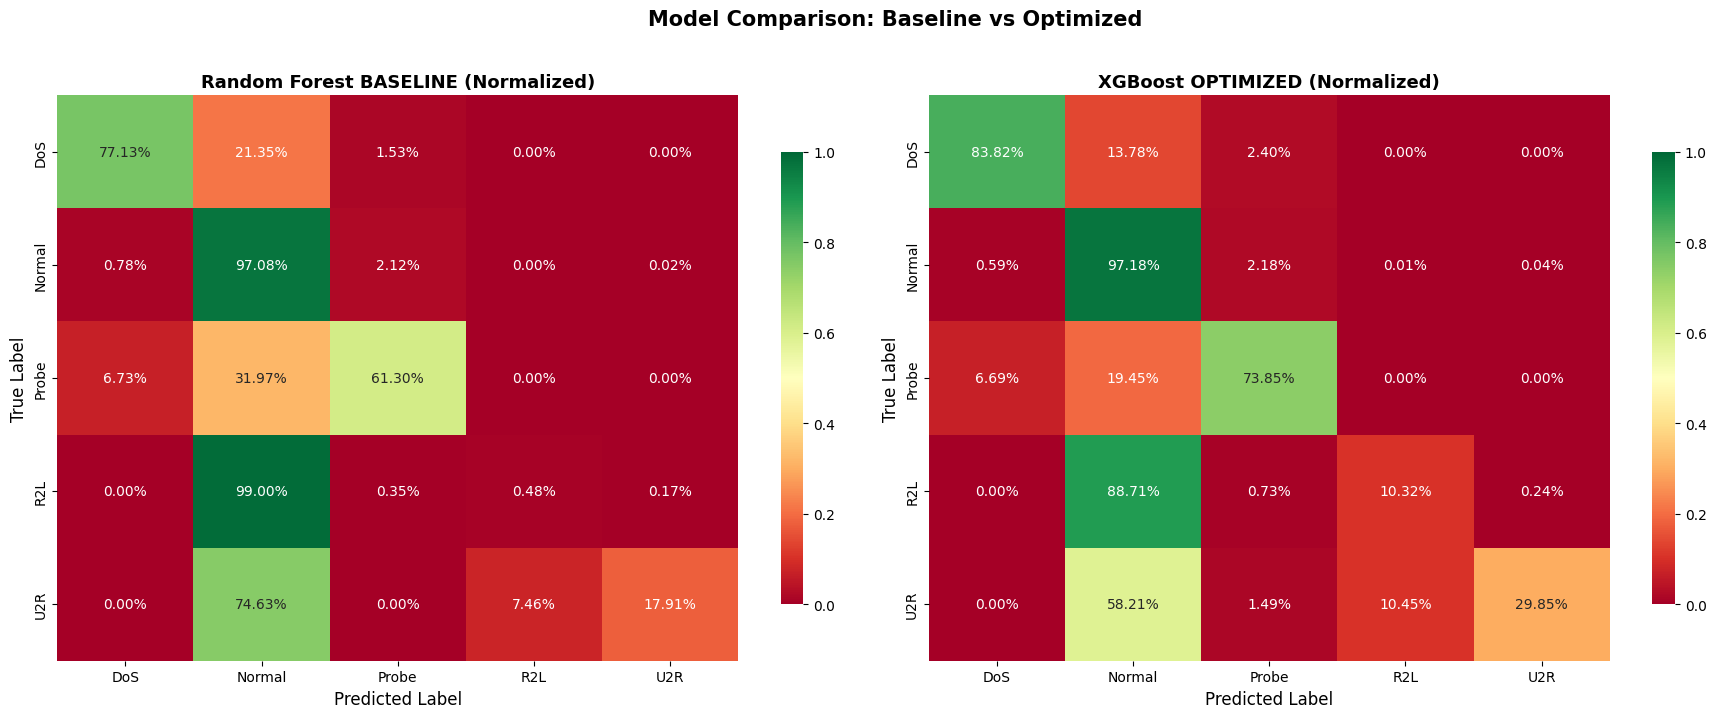

PER-CLASS RECALL IMPROVEMENT:
  Class       RF Baseline    XGBoost     Change
  ------------------------------------------
  DoS              77.1%      83.8% ↑     +6.7%
  Normal           97.1%      97.2% ↑     +0.1%
  Probe            61.3%      73.9% ↑    +12.6%
  R2L               0.5%      10.3% ↑     +9.8%
  U2R              17.9%      29.9% ↑    +11.9%


In [19]:
# =============================================================================
# STEP 7C: Confusion Matrix — Optimized XGBoost vs Baseline Side-by-Side
# =============================================================================

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_xgb_norm = cm_xgb.astype('float') / cm_xgb.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Baseline RF (normalized)
cm_rf_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_rf_norm, annot=True, fmt='.2%', cmap='RdYlGn', xticklabels=class_names,
            yticklabels=class_names, ax=axes[0], vmin=0, vmax=1, cbar_kws={'shrink': 0.8})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Random Forest BASELINE (Normalized)', fontsize=13, fontweight='bold')

# Optimized XGBoost (normalized)
sns.heatmap(cm_xgb_norm, annot=True, fmt='.2%', cmap='RdYlGn', xticklabels=class_names,
            yticklabels=class_names, ax=axes[1], vmin=0, vmax=1, cbar_kws={'shrink': 0.8})
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('XGBoost OPTIMIZED (Normalized)', fontsize=13, fontweight='bold')

plt.suptitle('Model Comparison: Baseline vs Optimized', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Per-class improvement
print("PER-CLASS RECALL IMPROVEMENT:")
print(f"  {'Class':<10s} {'RF Baseline':>12s} {'XGBoost':>10s} {'Change':>10s}")
print(f"  {'-'*42}")
for i, cls in enumerate(class_names):
    rf_recall = cm_rf_norm[i, i]
    xgb_recall = cm_xgb_norm[i, i]
    delta = xgb_recall - rf_recall
    arrow = "↑" if delta > 0 else "↓" if delta < 0 else "="
    print(f"  {cls:<10s} {rf_recall:>11.1%} {xgb_recall:>10.1%} {arrow} {delta:>+9.1%}")

In [20]:
# =============================================================================
# STEP 8A: SHAP Global Explainability — What drives the model's decisions?
# =============================================================================
# SHAP (SHapley Additive exPlanations) uses game theory to explain
# individual predictions. It answers:
#   - Which features matter MOST to the model overall? (global)
#   - WHY did the model classify THIS specific connection as an attack? (local)
#
# In cybersecurity, explainability isn't optional — security analysts
# need to understand WHY an alert was triggered to take action.
# A black-box "this is an attack" with no explanation is useless.
# =============================================================================

print("=" * 60)
print("  COMPUTING SHAP VALUES")
print("=" * 60)
print("  Using TreeExplainer (exact SHAP for tree-based models)")
print("  This may take 1-2 minutes...")

# TreeExplainer is the fastest exact method for tree-based models
explainer = shap.TreeExplainer(xgb_model)

# Use a sample of test data for SHAP (full set would be slow)
# 2000 samples is more than enough for reliable explanations
np.random.seed(42)
sample_idx = np.random.choice(len(X_test_scaled), size=2000, replace=False)
X_test_sample = X_test_scaled.iloc[sample_idx]
y_test_sample = y_test[sample_idx]

# Compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

print(f"  SHAP values computed!")
print(f"  Shape: {np.array(shap_values).shape}")
print(f"  (classes × samples × features)")
print(f"\n  Class mapping:")
for i, cls in enumerate(target_encoder.classes_):
    print(f"    SHAP index {i} = {cls}")

  COMPUTING SHAP VALUES
  Using TreeExplainer (exact SHAP for tree-based models)
  This may take 1-2 minutes...
  SHAP values computed!
  Shape: (2000, 57, 5)
  (classes × samples × features)

  Class mapping:
    SHAP index 0 = DoS
    SHAP index 1 = Normal
    SHAP index 2 = Probe
    SHAP index 3 = R2L
    SHAP index 4 = U2R


  GLOBAL FEATURE IMPORTANCE (SHAP)


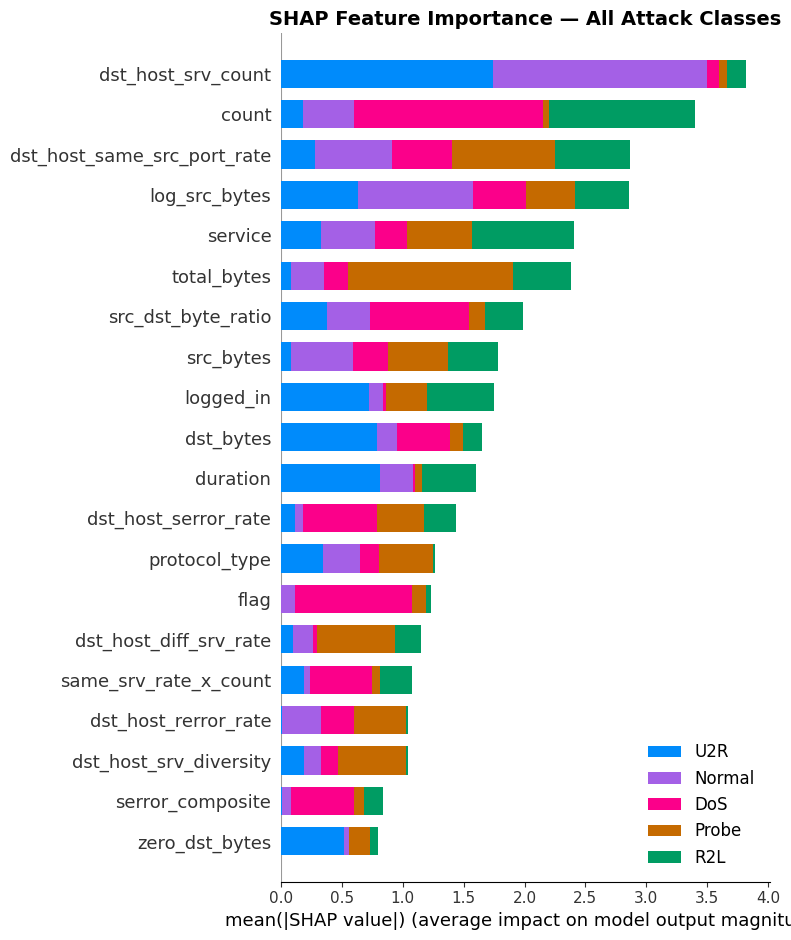

In [21]:
# =============================================================================
# STEP 8B: SHAP Summary Plot — Global Feature Importance (All Classes)
# =============================================================================
# This is the single most important visualization in the project.
# It shows, for EACH class, which features push the model toward
# or away from predicting that class.
# =============================================================================

# --- Plot 1: Bar plot — Mean absolute SHAP value per feature per class ---
print("=" * 60)
print("  GLOBAL FEATURE IMPORTANCE (SHAP)")
print("=" * 60)

fig, ax = plt.subplots(figsize=(12, 8))
shap.summary_plot(
    shap_values,
    X_test_sample,
    feature_names=feature_names,
    class_names=target_encoder.classes_.tolist(),
    plot_type='bar',
    max_display=20,
    show=False
)
plt.title('SHAP Feature Importance — All Attack Classes', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


  SHAP Beeswarm: DoS (class 0)


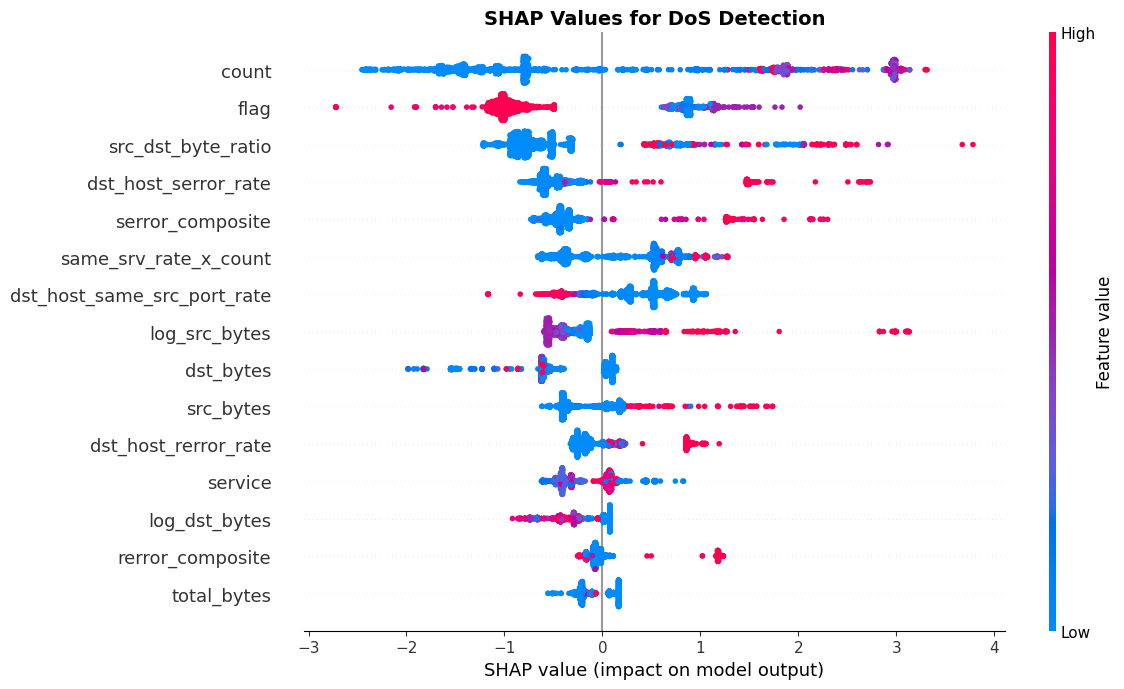


  SHAP Beeswarm: Normal (class 1)


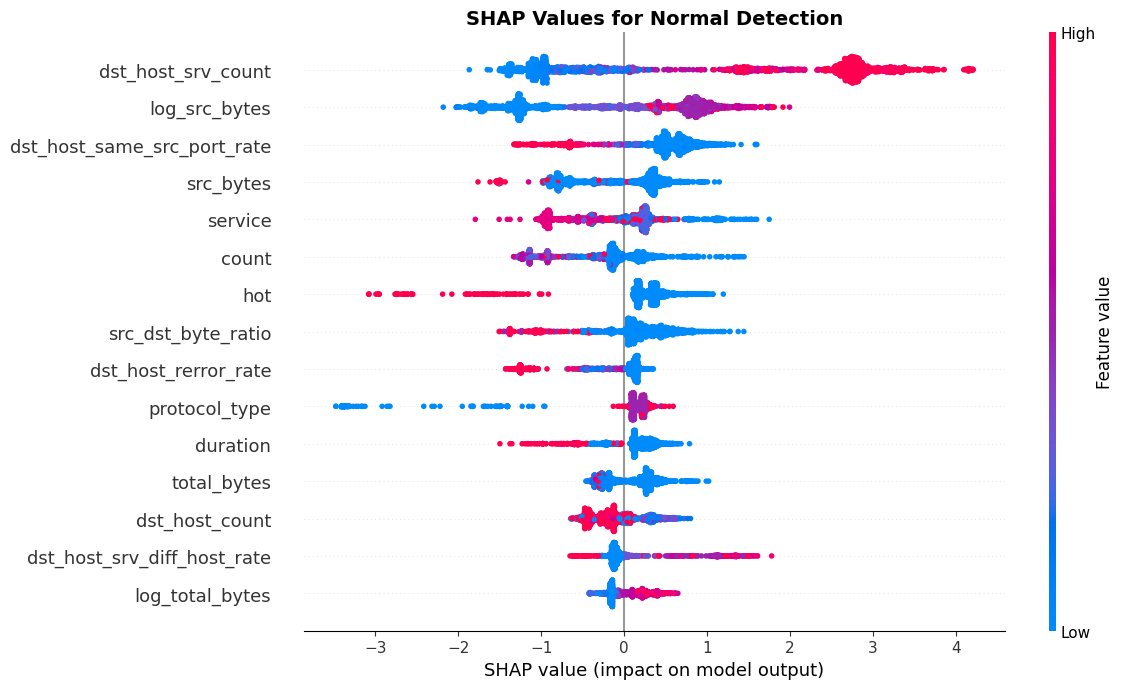


  SHAP Beeswarm: Probe (class 2)


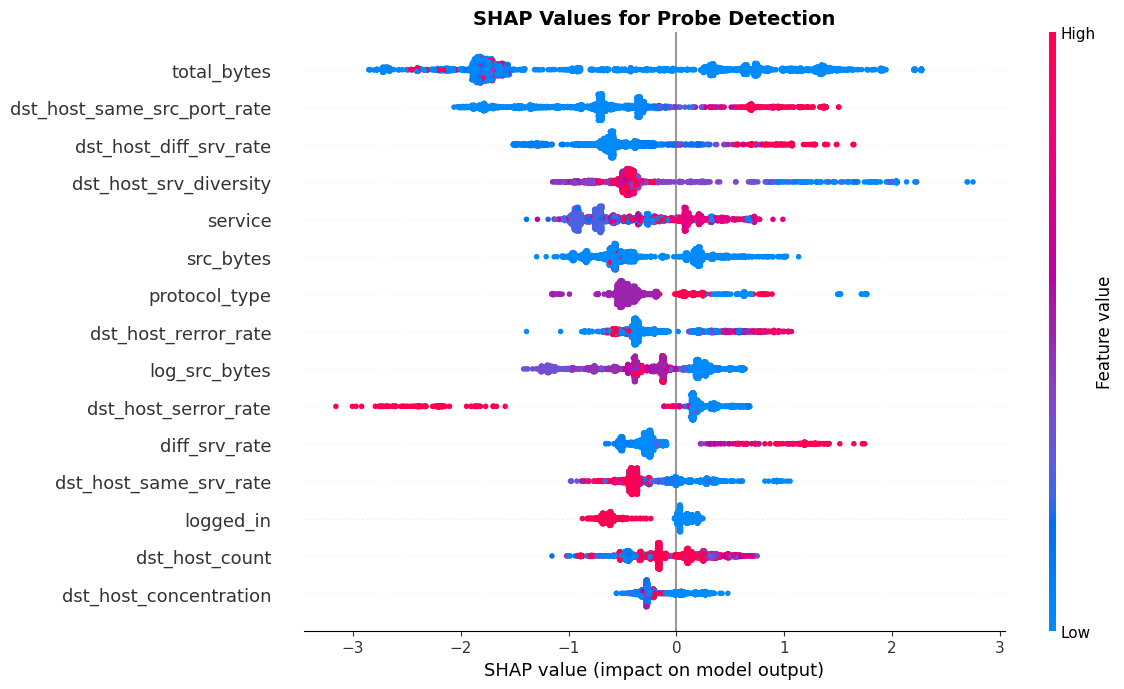


  SHAP Beeswarm: R2L (class 3)


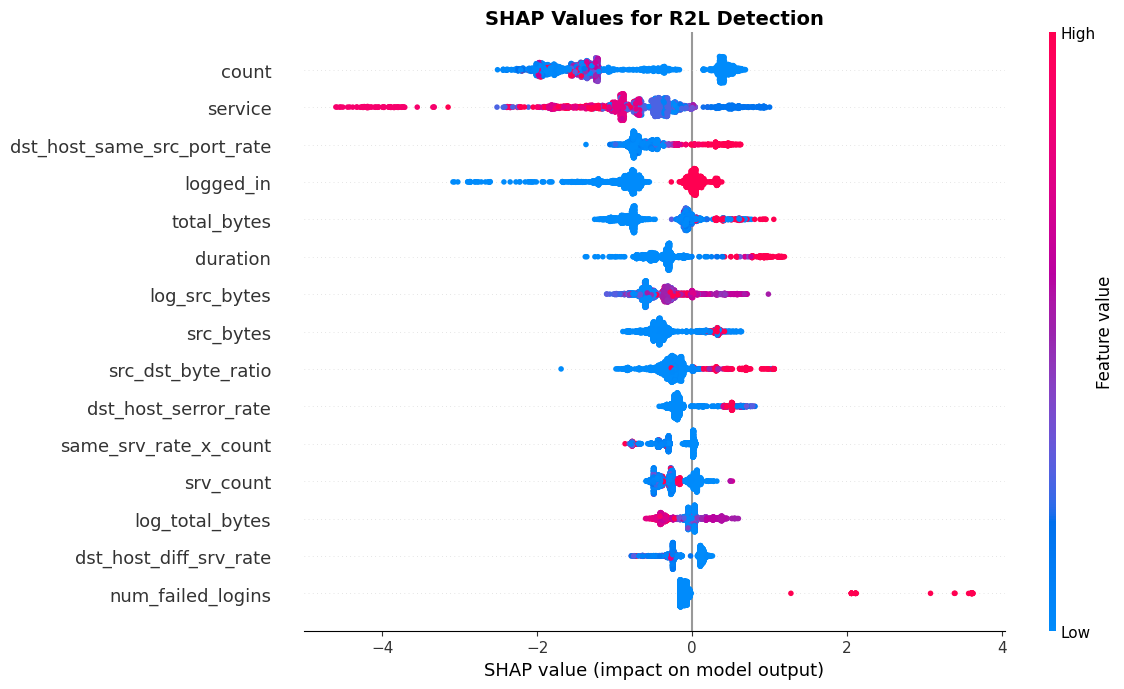


  SHAP Beeswarm: U2R (class 4)


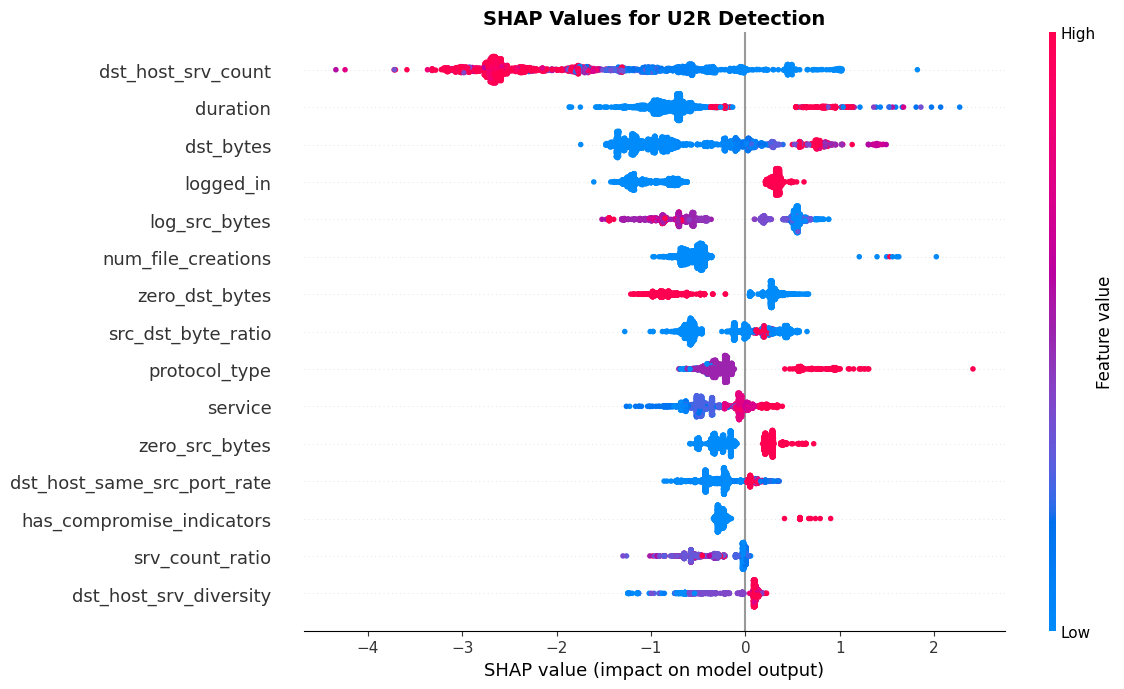

In [26]:
# =============================================================================
# STEP 8C: SHAP Beeswarm Plots — Per-Class Deep Dive (FIXED)
# =============================================================================
# SHAP values shape is (samples, features, classes) in newer SHAP versions.
# We slice on axis 2 (the class dimension) to get per-class explanations.
# =============================================================================

classes_to_explain = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']

for cls_name in classes_to_explain:
    cls_idx = list(target_encoder.classes_).index(cls_name)
    print(f"\n{'='*60}")
    print(f"  SHAP Beeswarm: {cls_name} (class {cls_idx})")
    print(f"{'='*60}")

    # Extract SHAP values for this specific class
    # Shape: (2000, 57, 5) → slice [:, :, cls_idx] → (2000, 57)
    class_shap_values = shap_values[:, :, cls_idx]

    plt.figure(figsize=(12, 7))
    shap.summary_plot(
        class_shap_values,
        X_test_sample,
        feature_names=feature_names,
        max_display=15,
        show=False,
        plot_size=(12, 7)
    )
    plt.title(f'SHAP Values for {cls_name} Detection', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

  LOCAL SHAP EXPLANATIONS — Individual Predictions

  Explaining a DoS detection (sample index 1)
  True label: DoS | Predicted: DoS ✓


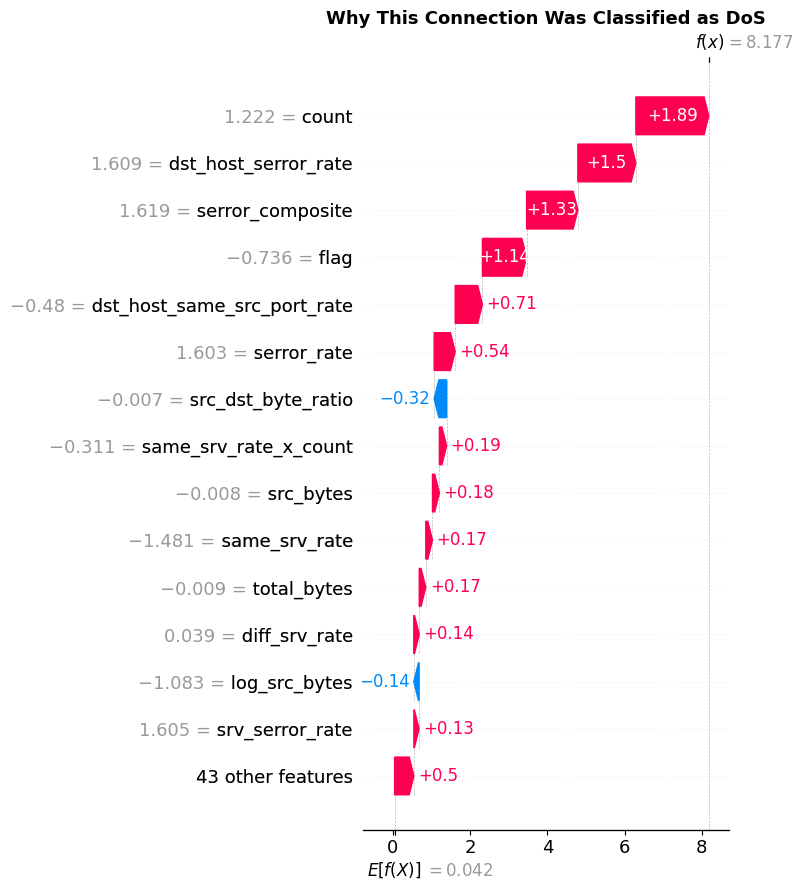


  Explaining a Probe detection (sample index 5)
  True label: Probe | Predicted: Probe ✓


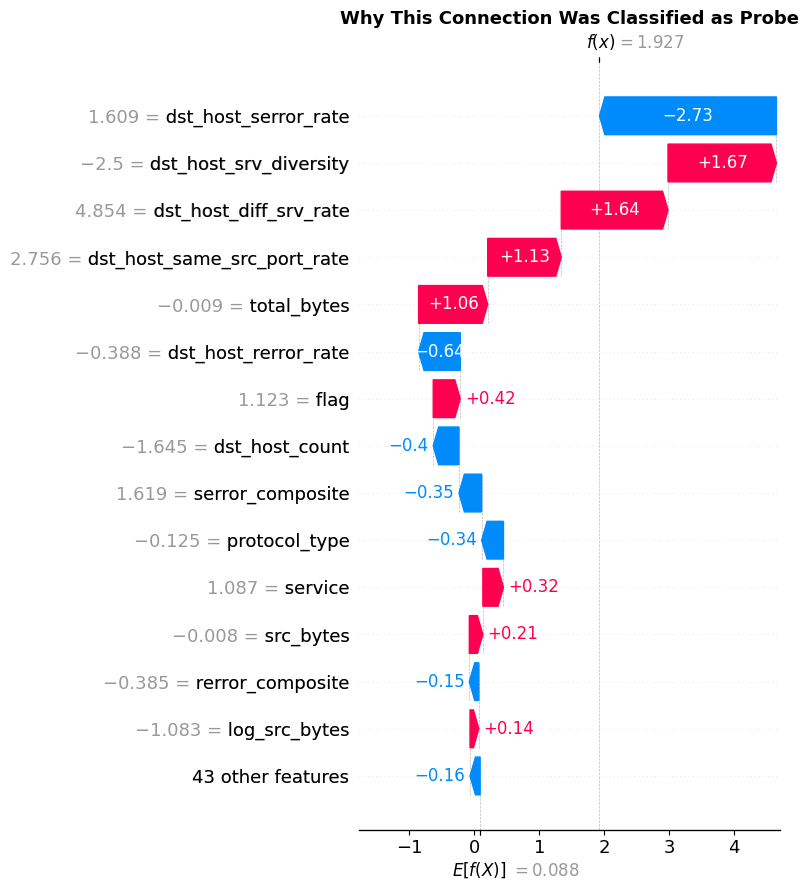


  Explaining a U2R detection (sample index 627)
  True label: U2R | Predicted: U2R ✓


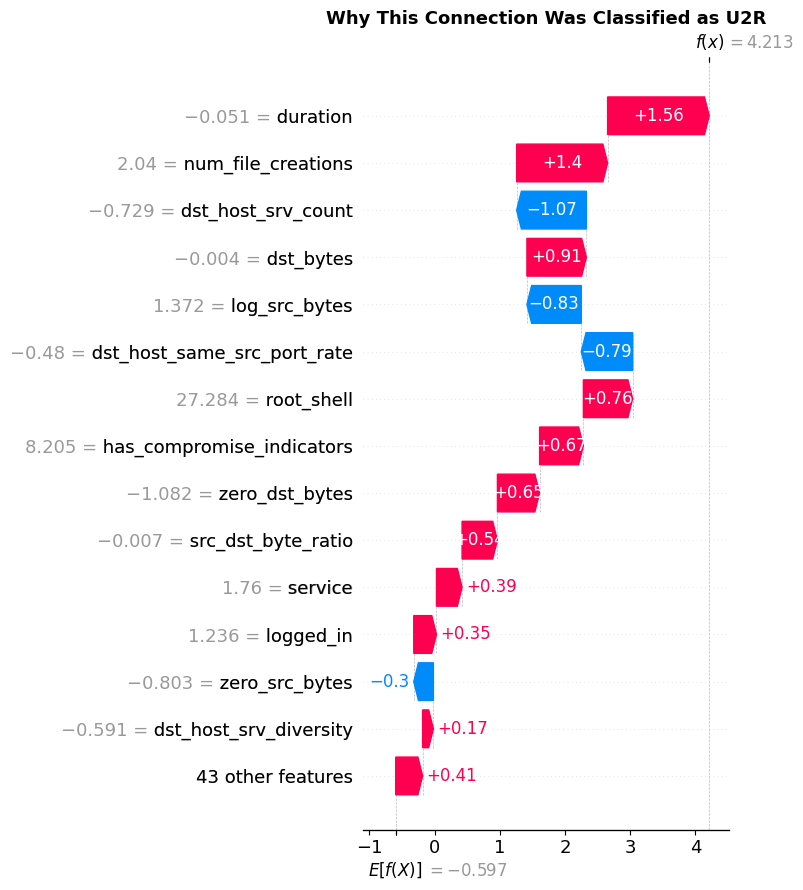

In [27]:
# =============================================================================
# STEP 9A: SHAP Local Explanation — Explain a SINGLE Prediction
# =============================================================================
# Global plots show overall patterns. Local explanations show WHY the
# model made a specific decision for ONE connection.
# This is what a SOC analyst would see: "This connection was flagged as
# DoS because of X, Y, Z features."
# =============================================================================

# Find one correctly classified example of each attack type
print("=" * 60)
print("  LOCAL SHAP EXPLANATIONS — Individual Predictions")
print("=" * 60)

y_pred_sample = xgb_model.predict(X_test_sample)

for cls_name in ['DoS', 'Probe', 'U2R']:
    cls_idx = list(target_encoder.classes_).index(cls_name)

    # Find a correctly classified sample of this class
    mask = (y_test_sample == cls_idx) & (y_pred_sample == cls_idx)
    correct_indices = np.where(mask)[0]

    if len(correct_indices) == 0:
        print(f"\n  No correctly classified {cls_name} samples in subset. Skipping.")
        continue

    sample_i = correct_indices[0]

    print(f"\n{'='*60}")
    print(f"  Explaining a {cls_name} detection (sample index {sample_i})")
    print(f"  True label: {cls_name} | Predicted: {cls_name} ✓")
    print(f"{'='*60}")

    # SHAP waterfall plot for this specific prediction
    # Get the SHAP explanation for this sample and class
    sample_shap = shap_values[sample_i, :, cls_idx]

    # Create an Explanation object for the waterfall plot
    explanation = shap.Explanation(
        values=sample_shap,
        base_values=explainer.expected_value[cls_idx],
        data=X_test_sample.iloc[sample_i].values,
        feature_names=feature_names
    )

    plt.figure(figsize=(12, 7))
    shap.waterfall_plot(explanation, max_display=15, show=False)
    plt.title(f'Why This Connection Was Classified as {cls_name}',
              fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

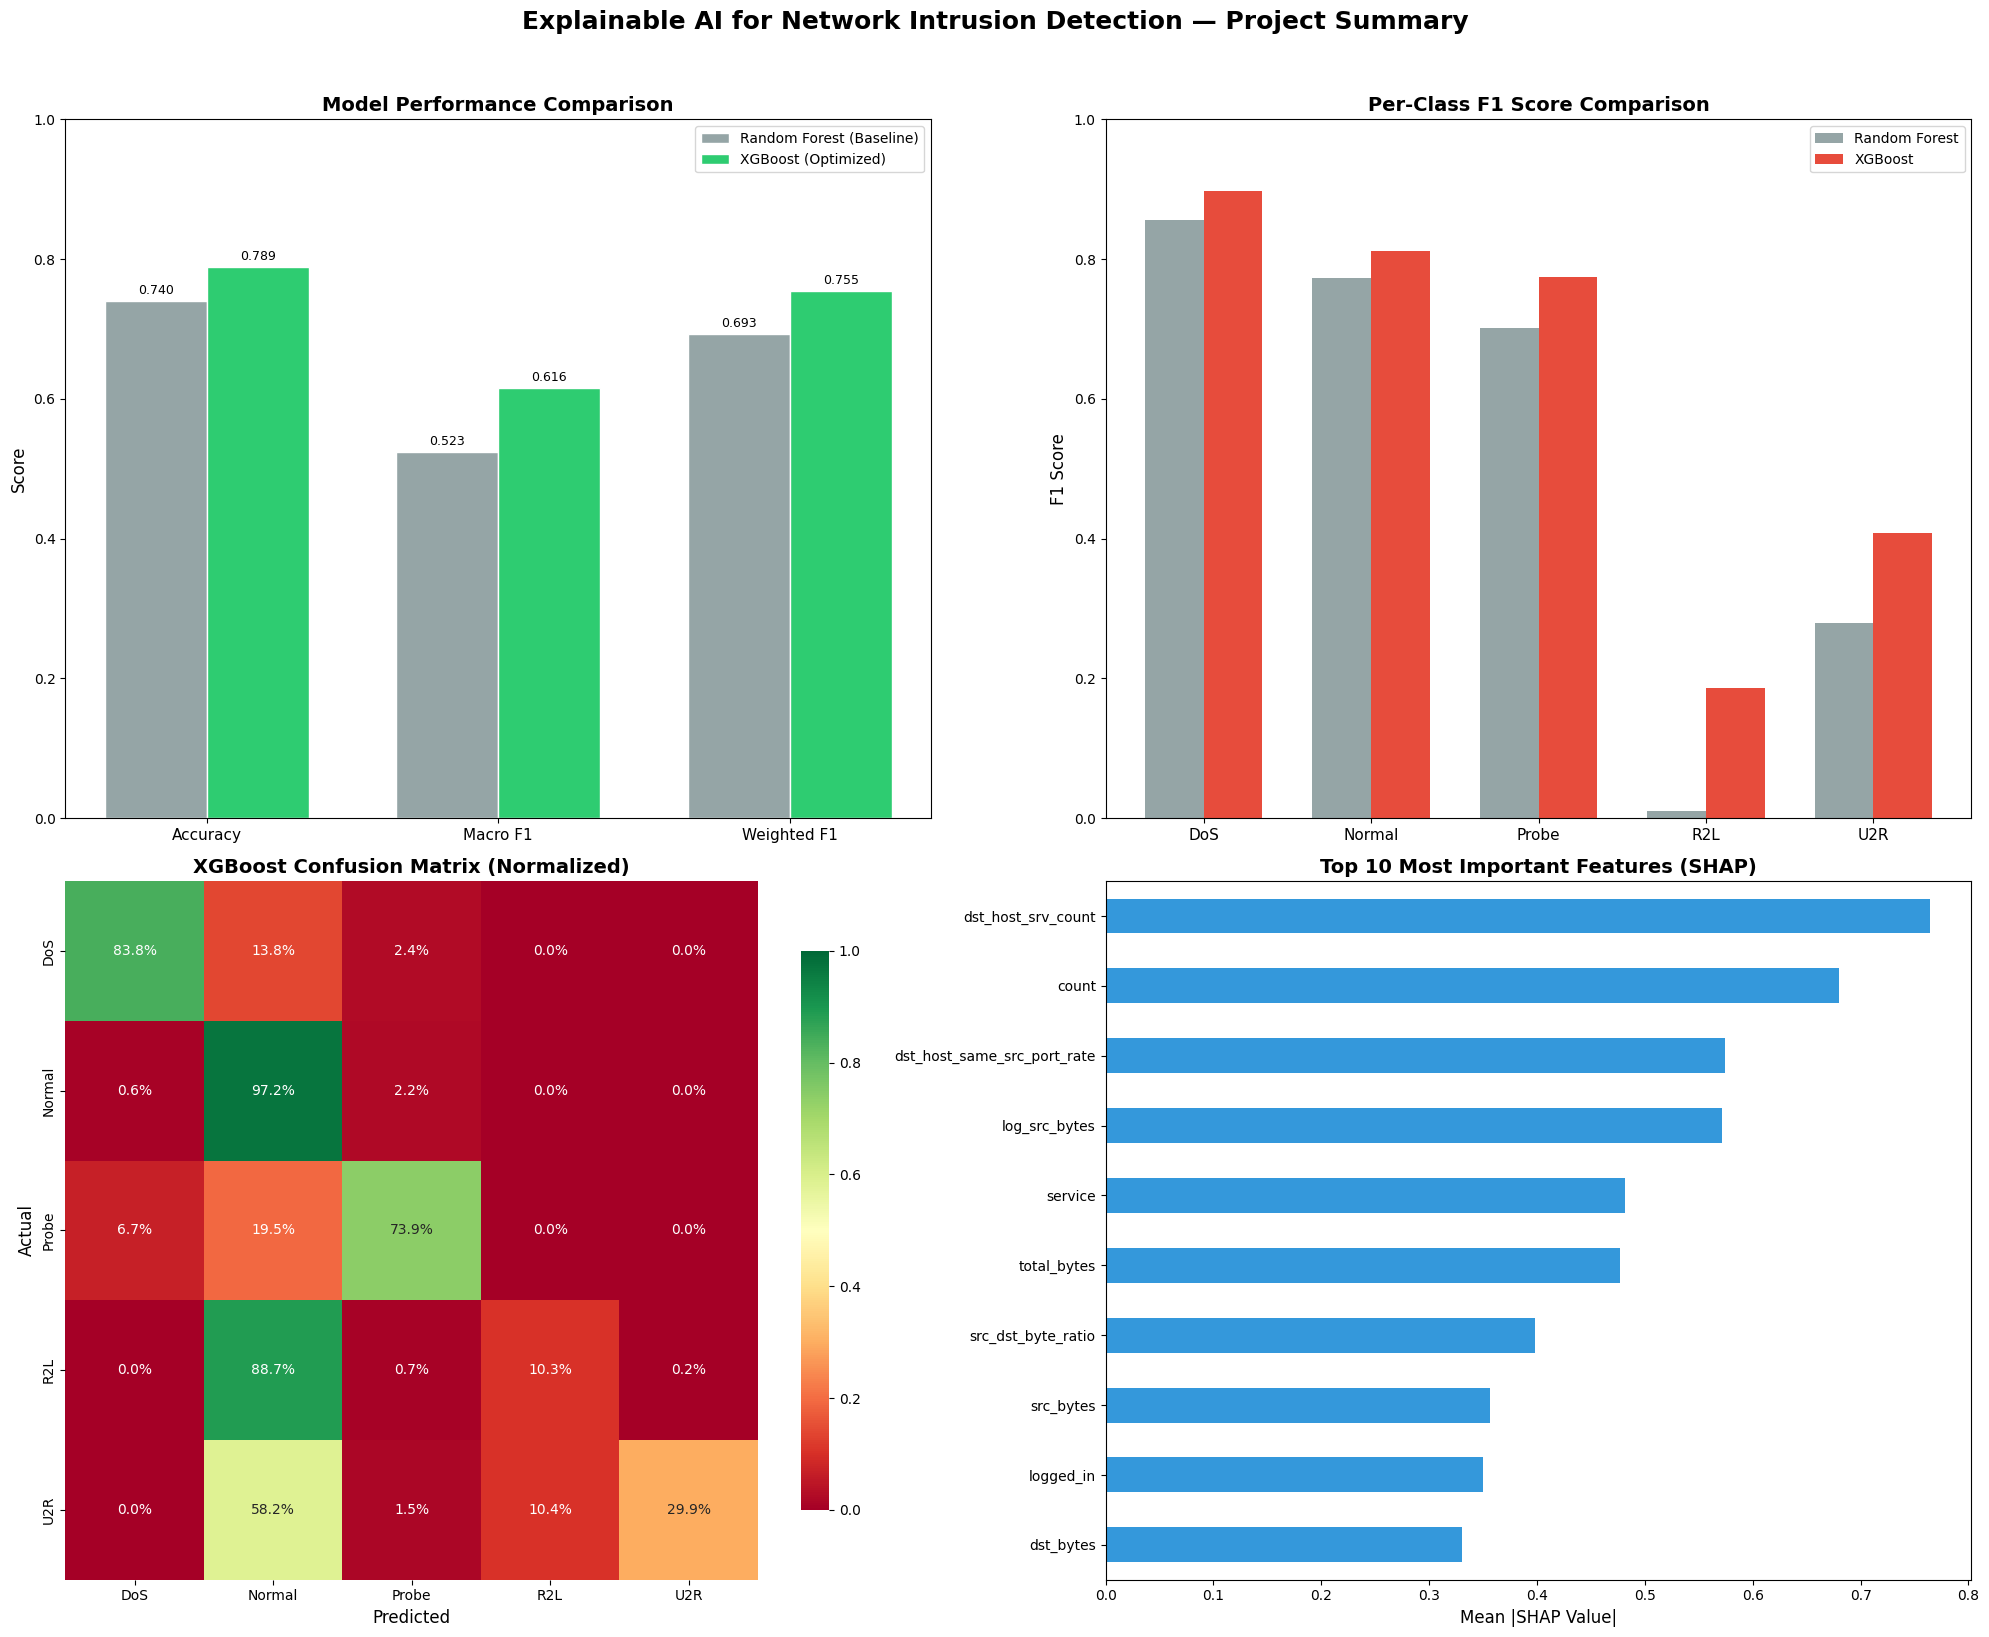

  PROJECT COMPLETE!
  Dataset:        NSL-KDD (125,973 train / 22,544 test)
  Features:       57 (41 original + 16 engineered)
  Classes:        5 (Normal, DoS, Probe, R2L, U2R)
  Imbalance:      Handled with SMOTE (R2L: 995->8K, U2R: 52->4K)
  Baseline:       Random Forest — Macro F1: 0.5234
  Final Model:    XGBoost + Optuna — Macro F1: 0.6156
  Improvement:    +0.0922 Macro F1 (17.6% relative)
  Explainability: SHAP (global + local explanations)


In [29]:
# =============================================================================
# STEP 9B: Final Project Summary Dashboard
# =============================================================================
# A polished summary visualization that ties everything together.
# This is the "money shot" for your portfolio and README.
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# --- Plot 1: Model Comparison Bar Chart ---
ax1 = axes[0, 0]
metrics = ['Accuracy', 'Macro F1', 'Weighted F1']
rf_scores = [acc, f1_macro, f1_weighted]
xgb_scores = [acc_xgb, f1_macro_xgb, f1_weighted_xgb]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, rf_scores, width, label='Random Forest (Baseline)',
                color='#95a5a6', edgecolor='white')
bars2 = ax1.bar(x + width/2, xgb_scores, width, label='XGBoost (Optimized)',
                color='#2ecc71', edgecolor='white')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, fontsize=11)
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1)
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{bar.get_height():.3f}', ha='center', fontsize=9)
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{bar.get_height():.3f}', ha='center', fontsize=9)

# --- Plot 2: Per-Class F1 Comparison ---
ax2 = axes[0, 1]
rf_report = classification_report(y_test, y_pred_rf, target_names=target_encoder.classes_,
                                   output_dict=True)
xgb_report = classification_report(y_test, y_pred_xgb, target_names=target_encoder.classes_,
                                    output_dict=True)
classes = list(target_encoder.classes_)
rf_f1s = [rf_report[c]['f1-score'] for c in classes]
xgb_f1s = [xgb_report[c]['f1-score'] for c in classes]
x = np.arange(len(classes))
bars1 = ax2.bar(x - width/2, rf_f1s, width, label='Random Forest', color='#95a5a6')
bars2 = ax2.bar(x + width/2, xgb_f1s, width, label='XGBoost', color='#e74c3c')
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_title('Per-Class F1 Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(classes, fontsize=11)
ax2.legend(fontsize=10)
ax2.set_ylim(0, 1)

# --- Plot 3: XGBoost Confusion Matrix (Normalized) ---
ax3 = axes[1, 0]
sns.heatmap(cm_xgb_norm, annot=True, fmt='.1%', cmap='RdYlGn',
            xticklabels=class_names, yticklabels=class_names, ax=ax3,
            vmin=0, vmax=1, cbar_kws={'shrink': 0.8})
ax3.set_xlabel('Predicted', fontsize=12)
ax3.set_ylabel('Actual', fontsize=12)
ax3.set_title('XGBoost Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')

# --- Plot 4: SHAP Global Importance (Top 10) ---
ax4 = axes[1, 1]
# Compute mean absolute SHAP across all classes
mean_shap = np.abs(shap_values).mean(axis=(0, 2))  # Average over samples and classes
feat_importance = pd.Series(mean_shap, index=feature_names).sort_values(ascending=True)
top10 = feat_importance.tail(10)
top10.plot(kind='barh', ax=ax4, color='#3498db')
ax4.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax4.set_title('Top 10 Most Important Features (SHAP)', fontsize=14, fontweight='bold')

fig.suptitle('Explainable AI for Network Intrusion Detection — Project Summary',
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("=" * 60)
print("  PROJECT COMPLETE!")
print("=" * 60)
print(f"  Dataset:        NSL-KDD ({len(df_train):,} train / {len(df_test):,} test)")
print(f"  Features:       57 (41 original + 16 engineered)")
print(f"  Classes:        5 (Normal, DoS, Probe, R2L, U2R)")
print(f"  Imbalance:      Handled with SMOTE (R2L: 995->8K, U2R: 52->4K)")
print(f"  Baseline:       Random Forest — Macro F1: {f1_macro:.4f}")
print(f"  Final Model:    XGBoost + Optuna — Macro F1: {f1_macro_xgb:.4f}")
print(f"  Improvement:    +{(f1_macro_xgb - f1_macro):.4f} Macro F1 ({(f1_macro_xgb - f1_macro)/f1_macro*100:.1f}% relative)")
print(f"  Explainability: SHAP (global + local explanations)")